In [17]:
import numpy as np
import pandas as pd
import scipy.stats

pd.options.mode.chained_assignment = None
from matplotlib import pyplot as plt, rcParams
# import cv2
import seaborn as sns

sns.set(style="white", context="paper")
from cycler import cycler
import os, sys
import glob
from datetime import datetime, timedelta
from itertools import combinations, product
import base64
from PIL import Image
from io import BytesIO as _BytesIO
import requests
import json
import pickle
from datetime import datetime
from IPython.display import display, Markdown, Latex
from sklearn.metrics import *
import collections
from copy import deepcopy
import traceback
from sympy import Point, Polygon
from decorators import *
from smartprint import smartprint as sprint
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
# import plotly
# from pandas_profiling import ProfileReport

pd.options.display.max_columns = None
def printm(s): return display(Markdown(s))
    
SERVER_CACHE_DIR = '/mnt/ci-nas-cache/edulyzeV2/cache_compute_4/fixed_face'
os.makedirs(SERVER_CACHE_DIR,exist_ok=True)

track_analysis_meta_cache = f'{SERVER_CACHE_DIR}/analysis_tracking/meta_info'
base_dir = '/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb_fixed_face/'

track_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_tracking/session_tracking_info'
os.makedirs(track_analysis_session_data,exist_ok=True)

postprocessed_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/processed_id_maps'
os.makedirs(postprocessed_id_map_data_dir, exist_ok=True)

emb_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_emb/session_emb_info_new'
os.makedirs(emb_analysis_session_data,exist_ok=True)

embmatched_id_raw_data_dir = f'{SERVER_CACHE_DIR}/analysis_emb/embmatched_id_raw'
os.makedirs(embmatched_id_raw_data_dir,exist_ok=True)

embmatched_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/embmatched_id_maps'
os.makedirs(embmatched_id_map_data_dir, exist_ok=True)

cross_session_input_data_dir = f'{SERVER_CACHE_DIR}/analysis_emb/cross_session_input'
os.makedirs(cross_session_input_data_dir, exist_ok=True)

id_viz_cache_root = f'{SERVER_CACHE_DIR}/analysis_emb/session_matching_info'
os.makedirs(id_viz_cache_root, exist_ok=True)

## Get frame file data for all sessions

In [18]:

frame_file_data = {}
for course_idx, course_dir in enumerate(glob.glob(f"{base_dir}/*")):
    course_name = course_dir.split("/")[-1]
    course_cache_file = f"{track_analysis_meta_cache}/{course_name}"
    if os.path.exists(course_cache_file):
        frame_file_data[course_name] = pickle.load(open(course_cache_file,"rb"))
        continue
    frame_file_data[course_name]={}
        
    for session_idx, session_dir in enumerate(glob.glob(f"{course_dir}/*")):
        session_name = session_dir.split("/")[-1]
        frame_file_data[course_name][session_name] = {}
        frame_files = glob.glob(f"{session_dir}/*")
        frame_file_names = [xr.split("/")[-1] for xr in frame_files]
        if 'end.pb' in frame_file_names:
            frame_file_data[course_name][session_name]['is_completed']=True
        else:
            frame_file_data[course_name][session_name]['is_completed']=False            
        frame_ids = [int(xr.split(".")[0]) for xr in frame_file_names if not (xr=='end.pb')]
        frame_file_data[course_name][session_name]['frame_ids'] = sorted(frame_ids)
        frame_file_data[course_name][session_name]['dir_location'] = session_dir
        print(f"Got metadata for course: {course_idx}-{course_name}, session:{session_idx}-{session_name}")
    pickle.dump(frame_file_data[course_name],open(course_cache_file,"wb")) 
        
frame_file_data.keys()

Got metadata for course: 0-05748A, session:0-classinsight-cmu_05748A_ghc_4101_201902051630-front
Got metadata for course: 0-05748A, session:1-classinsight-cmu_05748A_ghc_4101_201902141630-front
Got metadata for course: 0-05748A, session:2-classinsight-cmu_05748A_ghc_4101_201901291630-front
Got metadata for course: 0-05748A, session:3-classinsight-cmu_05748A_ghc_4101_201901311630-front
Got metadata for course: 0-05748A, session:4-classinsight-cmu_05748A_ghc_4101_201902071630-front
Got metadata for course: 0-05748A, session:5-classinsight-cmu_05748A_ghc_4101_201902121630-front
Got metadata for course: 0-05748A, session:6-classinsight-cmu_05748A_ghc_4101_201902191630-front
Got metadata for course: 0-05748A, session:7-classinsight-cmu_05748A_ghc_4101_201902211630-front
Got metadata for course: 0-05748A, session:8-classinsight-cmu_05748A_ghc_4101_201902281630-front
Got metadata for course: 0-05748A, session:9-classinsight-cmu_05748A_ghc_4101_201903051630-front
Got metadata for course: 0-057

dict_keys(['05748A', '05410B', '17214C', '17214B', '05681A', '24352A', '24352C', '86375A'])

In [3]:
session_filter_list = ['classinsight-cmu_05681A_ghc_4301_201905011630',
 'classinsight-cmu_05681A_ghc_4301_201904171630',
 'classinsight-cmu_05681A_ghc_4301_201902201630',
 'classinsight-cmu_05681A_ghc_4301_201904101630',
 'classinsight-cmu_05681A_ghc_4301_201901231630',
 'classinsight-cmu_05418A_ghc_4102_201902251200',
 'classinsight-cmu_05418A_ghc_4102_201904081200',
 'classinsight-cmu_05418A_ghc_4102_201905011200',
 'classinsight-cmu_05418A_ghc_4102_201904291200',
 'classinsight-cmu_05418A_ghc_4102_201904011200',
 'classinsight-cmu_05748A_ghc_4101_201902141630',
 'classinsight-cmu_05748A_ghc_4101_201904021630',
 'classinsight-cmu_05748A_ghc_4101_201902051630',
 'classinsight-cmu_05748A_ghc_4101_201902281630',
 'classinsight-cmu_05748A_ghc_4101_201903071630',
 'classinsight-cmu_21127J_ghc_4102_201904230930',
 'classinsight-cmu_21127J_ghc_4102_201903260930',
 'classinsight-cmu_21127J_ghc_4102_201904160930',
 'classinsight-cmu_21127J_ghc_4102_201904300930',
 'classinsight-cmu_21127J_ghc_4102_201903190930',
 'classinsight-cmu_05410A_ghc_4301_201904151500',
 'classinsight-cmu_05410A_ghc_4301_201902251500',
 'classinsight-cmu_05410A_ghc_4301_201904081500',
 'classinsight-cmu_05410A_ghc_4301_201904221500',
 'classinsight-cmu_05410A_ghc_4301_201902181500',
                       
 'classinsight-cmu_17214B_ph_a21_201902271030',
 'classinsight-cmu_17214B_ph_a21_201903061030',
 'classinsight-cmu_17214B_ph_a21_201904031030',
 'classinsight-cmu_17214B_ph_a21_201904101030',
 'classinsight-cmu_17214B_ph_a21_201904241030',
 'classinsight-cmu_17214C_ph_225b_201904031130',
 'classinsight-cmu_17214C_ph_225b_201904101130',
 'classinsight-cmu_17214C_ph_225b_201904171130',
 'classinsight-cmu_17214C_ph_225b_201904241130',
 'classinsight-cmu_17214C_ph_225b_201905011130',
 'classinsight-cmu_05410B_ghc_4211_201902111500',
 'classinsight-cmu_05410B_ghc_4211_201903181500',
 'classinsight-cmu_05410B_ghc_4211_201904081500',
 'classinsight-cmu_05410B_ghc_4211_201904151500',
 'classinsight-cmu_05410B_ghc_4211_201904221500',
 'classinsight-cmu_05410B_ghc_4211_201901281500'
]

In [4]:
course='05748A'
sessions = [xr for xr in session_filter_list if (course in xr)]
sessions

['classinsight-cmu_05748A_ghc_4101_201902141630',
 'classinsight-cmu_05748A_ghc_4101_201904021630',
 'classinsight-cmu_05748A_ghc_4101_201902051630',
 'classinsight-cmu_05748A_ghc_4101_201902281630',
 'classinsight-cmu_05748A_ghc_4101_201903071630']

In [5]:
# get input for all sessions
course_input_dict = {}
for session in sessions:
    session_input_file = f'{cross_session_input_data_dir}/{session}-front.pb'
    course_input_dict[session] = pickle.load(open(session_input_file,"rb"))
course_input_dict.keys()    

dict_keys(['classinsight-cmu_05748A_ghc_4101_201902141630', 'classinsight-cmu_05748A_ghc_4101_201904021630', 'classinsight-cmu_05748A_ghc_4101_201902051630', 'classinsight-cmu_05748A_ghc_4101_201902281630', 'classinsight-cmu_05748A_ghc_4101_201903071630'])

In [6]:
for session in sessions:
    sprint(session, course_input_dict[session].keys())

session, course_input_dict[session].keys() : classinsight-cmu_05748A_ghc_4101_201902141630 dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 30, 31, 34])
session, course_input_dict[session].keys() : classinsight-cmu_05748A_ghc_4101_201904021630 dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 20, 21, 22, 23, 24, 26, 27, 29, 30, 31, 32, 33, 34, 35])
session, course_input_dict[session].keys() : classinsight-cmu_05748A_ghc_4101_201902051630 dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 29, 31, 33, 34])
session, course_input_dict[session].keys() : classinsight-cmu_05748A_ghc_4101_201902281630 dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 34, 35, 36])
session, course_input_dict[session].keys() : classinsight-cmu_05748A_ghc_4101_201903071630 dict_keys([0, 1, 2, 3, 4,

In [7]:
course_input_dict[session][0].keys()

dict_keys(['bbox_width_med', 'bbox_height_med', 'bbox_width_iqd', 'bbox_height_iqd', 'face_width_med', 'face_height_med', 'face_width_iqd', 'face_height_iqd', 'face_x_med', 'face_y_med', 'face_x_iqd', 'face_y_iqd', 'cluster_emb', 'gaze_emb'])

In [8]:
sorted(sessions)

['classinsight-cmu_05748A_ghc_4101_201902051630',
 'classinsight-cmu_05748A_ghc_4101_201902141630',
 'classinsight-cmu_05748A_ghc_4101_201902281630',
 'classinsight-cmu_05748A_ghc_4101_201903071630',
 'classinsight-cmu_05748A_ghc_4101_201904021630']

# Experiments with networkX

In [255]:
# get top 2 matches across all session pairs
MATCH_THRESHOLD=0.4
node_set = set()
session_matches = {}
for (sessionA, sessionB) in product(sorted(sessions)[:2], sorted(sessions)[:2]):
    sessionA_key, sessionB_key = sessionA.split("_")[-1][4:8], sessionB.split("_")[-1][4:8]
    if not (sessionA==sessionB):
        # if sessionA not in session_matches:
        # match session A and session B based on gaze clustering
        match_scores = {}
        for idA,idB in product(course_input_dict[sessionA].keys(), course_input_dict[sessionB].keys()):
            gaze_embA, gaze_embB = course_input_dict[sessionA][idA]['gaze_emb'], course_input_dict[sessionB][idB]['gaze_emb']                
            if idA not in match_scores:
                match_scores[idA] = {}
            if gaze_embA is None or gaze_embB is None:
                match_scores[idA][idB] = np.inf
            else:
                match_distance = cdist(gaze_embA.reshape(1,-1), gaze_embB.reshape(1,-1))[0][0]
                match_scores[idA][idB] = match_distance
        df_match = pd.DataFrame(match_scores) 
        final_matches = []
        for col in df_match.columns:
            sessionB_matches = deepcopy(df_match[col]).sort_values().head(3).index.values
            for match_id in sessionB_matches:
                if match_scores[col][match_id]<MATCH_THRESHOLD:
                    final_matches.append((f'{sessionA_key}_{col}', f'{sessionB_key}_{match_id}', match_scores[col][match_id]))
                    node_set.add((sessionA_key, f'{sessionA_key}_{col}'))
                    node_set.add((sessionB_key,f'{sessionB_key}_{match_id}'))
        if sessionA_key not in session_matches:
            session_matches[sessionA_key]={}
        session_matches[sessionA_key][sessionB_key] = final_matches
                
        


In [256]:
node_list = list(node_set)
color_map=  {
    '0205':"red",
    '0214':"blue",
    '0228':"green",
    '0307':"black",
    '0402':'brown'
}
node_color = [color_map[xr[0]] for xr in node_list]
node_name = [xr[1] for xr in node_list]
node_ids = np.arange(len(node_name))

session_pos_val = ['0205', '0214', '0228', '0307', '0402']
edge_labels = np.concatenate([session_matches[xr][yr] for xr,yr in product(session_matches.keys(), session_matches.keys()) if not (xr==yr)])
edge_weights = [ round(1-float(xr[2]),2) for xr in edge_labels]
weighted_edge_ids = [(node_name.index(xr[0]), node_name.index(xr[1]), round(1-float(xr[2]),2)) for xr in edge_labels]
edge_ids = [(node_name.index(xr[0]), node_name.index(xr[1])) for xr in edge_labels]

len(edge_labels)

122

In [257]:
node_pos = {node_ids[nr]:(session_pos_val.index(node_list[nr][0]), int(node_name[nr].split("_")[1])*2) for nr in range(len(node_ids))}
# node_pos

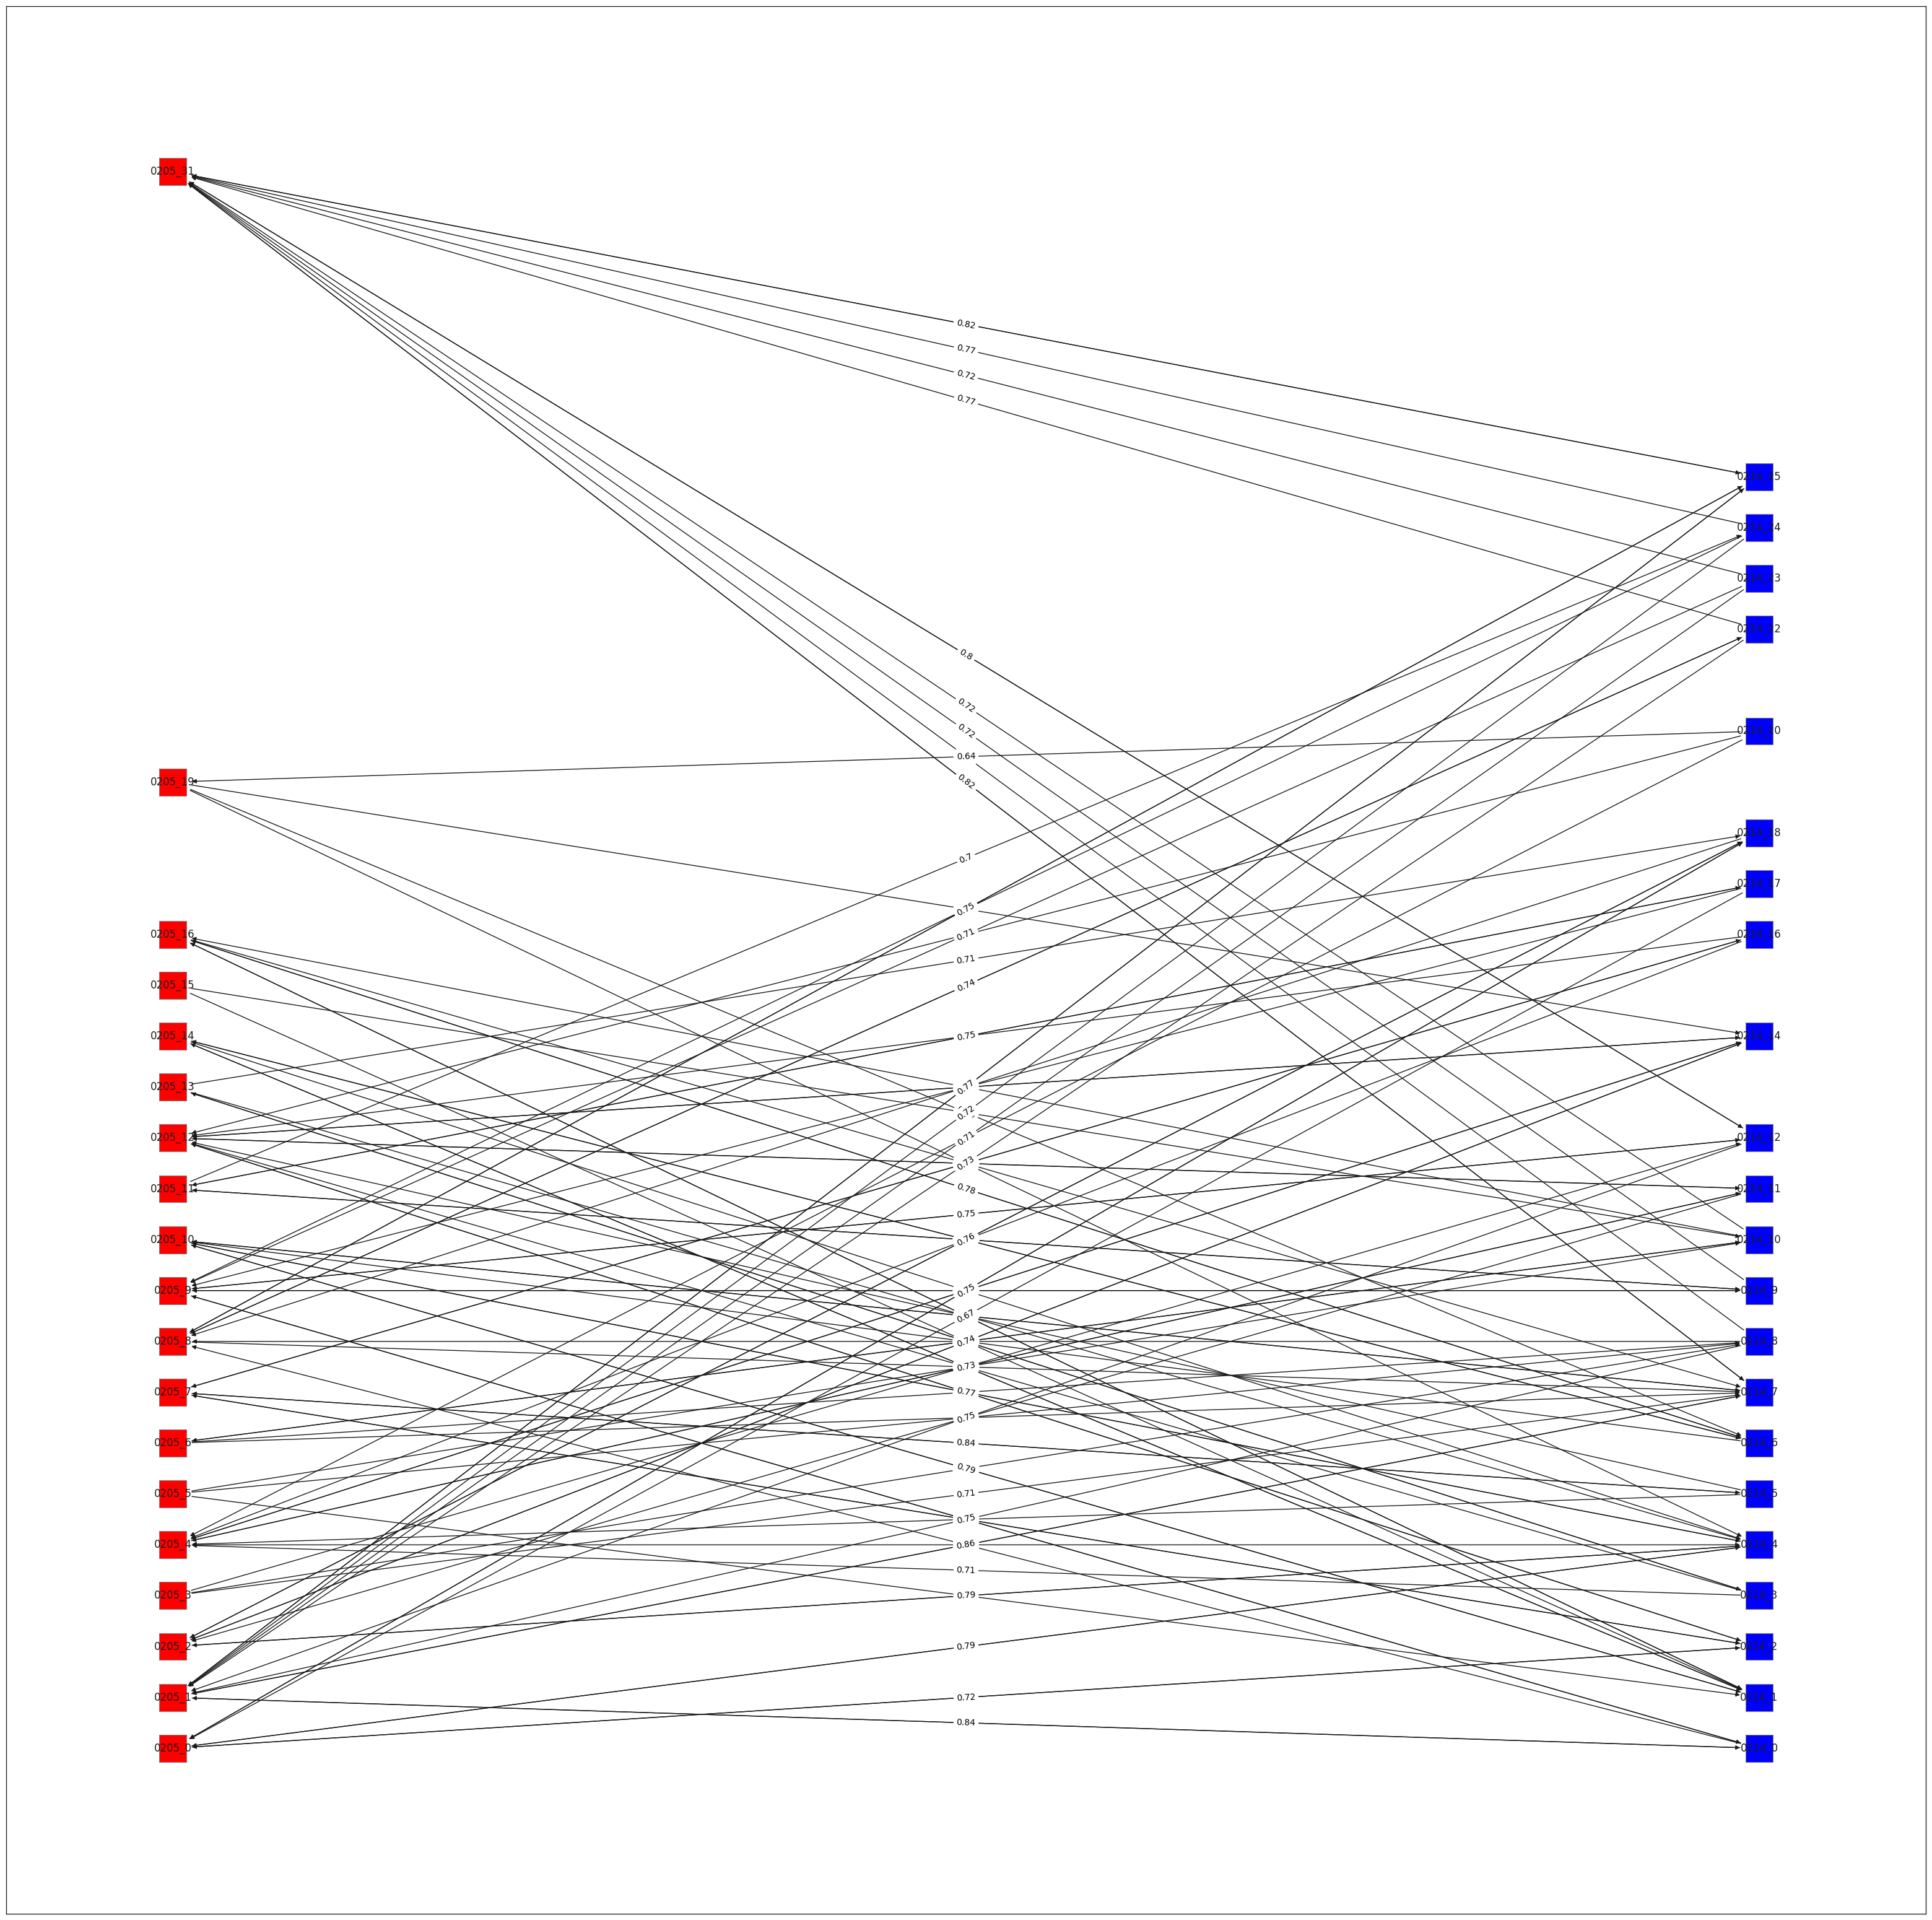

In [258]:
import networkx as nx
plt.figure(figsize=(40,40))
G = nx.DiGraph()
G.add_nodes_from(node_ids)
G.add_weighted_edges_from(weighted_edge_ids)
labels = {node_ids[nr]:node_name[nr] for nr in range(len(node_ids))}


nx.draw_networkx(G, pos = node_pos, labels = labels, arrows = True,
                 node_shape = "s", node_size=1000,
                 node_color = node_color,
                 # edgelist=edge_ids, 
                 # edge_color=edge_weights,
                 edgecolors = "gray")     #edges of the box of node
nx.draw_networkx_edge_labels(G, pos = node_pos,
                             edge_labels={edge_ids[nr]:edge_weights[nr] for nr in range(len(edge_weights))},
                             font_color='black')

plt.show()

In [259]:
session_matches.keys()

dict_keys(['0205', '0214'])

In [260]:
# get a filtered graph using only connections from one single edge
def drawnodegraph(graph, nodename, info=False,weightbar=0):
  # graph will be your networkx graph
  # nodename will be the node that you want to focus on
  # the default value for weightbar is 0, if increase the bar, rare relationship will be removed. Assuming no negative weights
  temp = graph.copy(as_view=False) # make a temporary graph to avoid losing original ones
  temp.remove_edges_from((e for e, w in nx.get_edge_attributes(temp,'weight').items() if w <= weightbar)) # remove rare relationhsip if weightbar is not 0
  nodelist = list(temp.neighbors(n=nodename)) #generate the nodes that have relationship with our target node
  nodelist.append(nodename) # add the target to the list
  print(nodelist)
  Sub = temp.subgraph(nodelist) # draw subgraph
  
  edges,weights = zip(*nx.get_edge_attributes(Sub,'weight').items())
  # pos=nx.spring_layout(Sub,k=0.7,seed=42)
  node_map = {nodename:7000} 
  nodesize=[node_map.get(node, 3500) for node in Sub.nodes()] # enlarge our target node
  # val_map = {nodename:0.5714285714285714}
  # nodecolor = [val_map.get(node, 0.25) for node in Sub.nodes()] # change the color of our target node
  width = [w*2 for w in weights] # change the edge's width based on the weights of the edges
  # nodecolor = 
  print({xr: node_pos[xr] for xr in nodelist})
  nx.draw_networkx(Sub,
                   pos = {xr: node_pos[xr] for xr in nodelist},
                   # cmap=plt.get_cmap('viridis'),
                   with_labels=True,
                   labels = {xr:node_name[xr] for xr in nodelist}, 
                   node_color=[node_color[xr] for xr in Sub.nodes],
                   node_size=nodesize,
                   # edgelist=edges, 
                   edge_color="black",
                   #edge_cmap=plt.cm.Blues_r,
                   style="solid",
                   font_color='white',
                   font_size=12,
                   width =width,
                  connectionstyle="arc3,rad=0.05")
  plt.subplots_adjust(left=2, bottom=3.2, right=6, top=6)

  # if info:
  #   print("----------------------------------------")
  #   print("Density:",nx.classes.function.density(Sub))
  #   print("The information of the graph:",nx.info(Sub))
  #   print("----------------------------------------")

  return plt.show()

[16, 22, 27, 5]
{16: (1, 10), 22: (1, 32), 27: (1, 4), 5: (0, 14)}


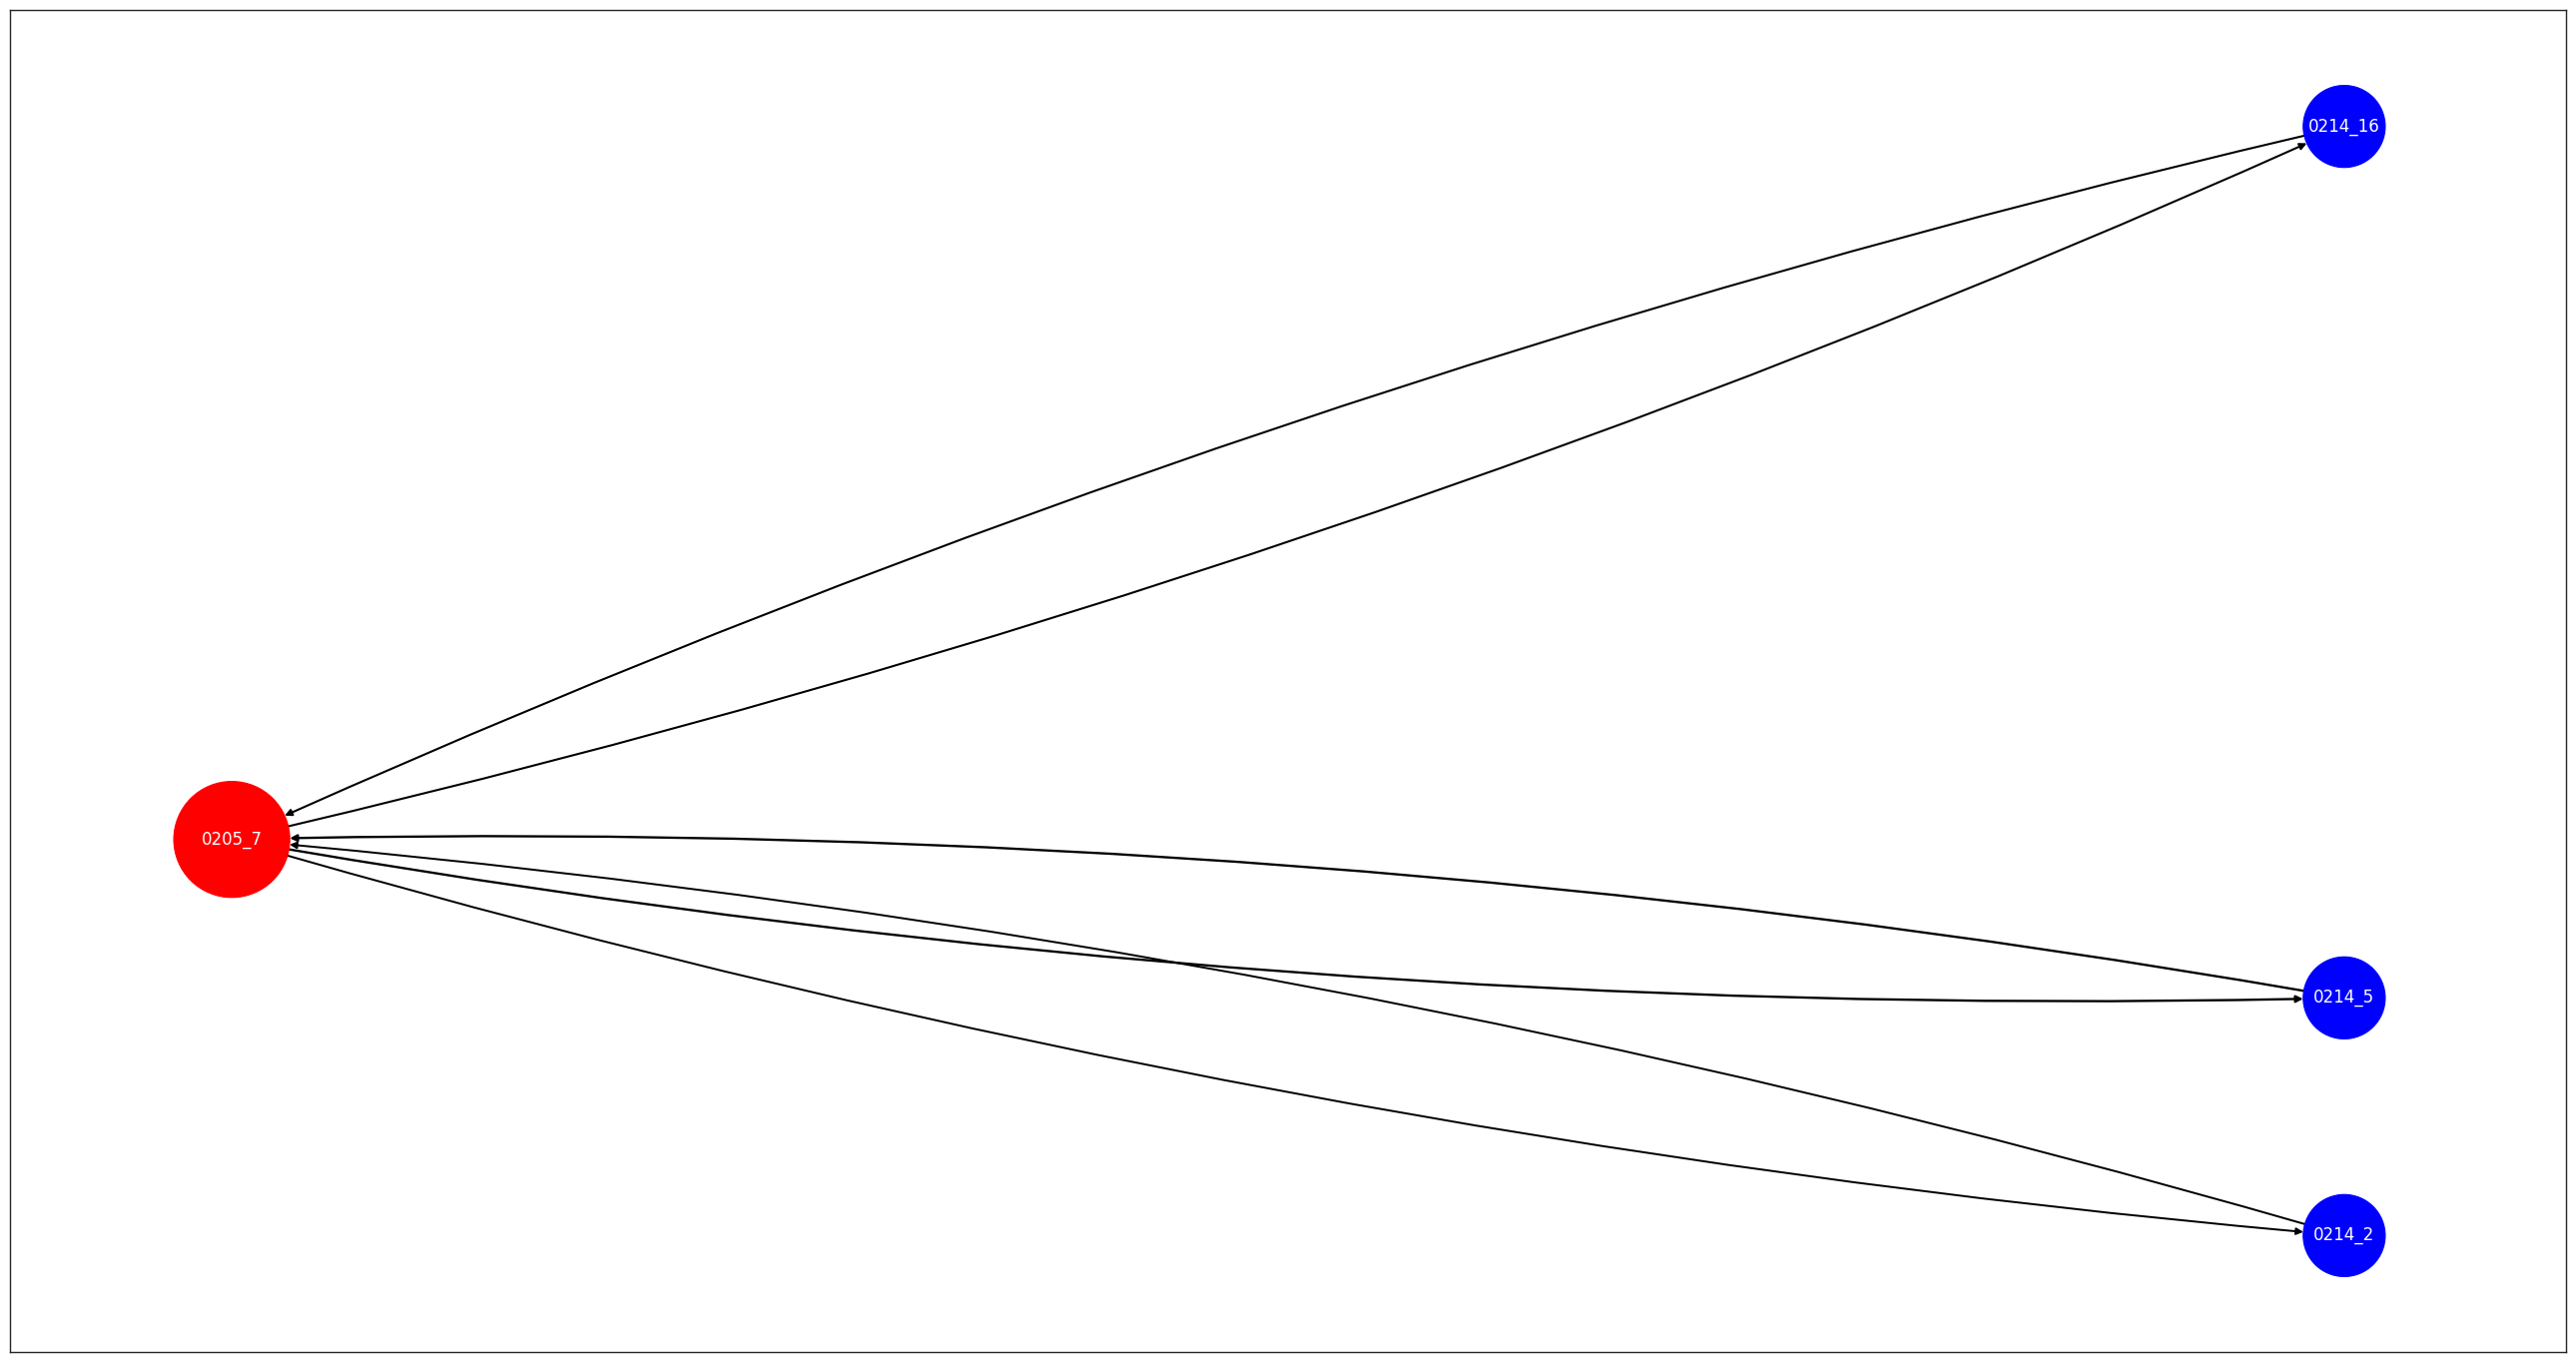

[5, 20, 0, 16]
{5: (0, 14), 20: (0, 24), 0: (0, 8), 16: (1, 10)}


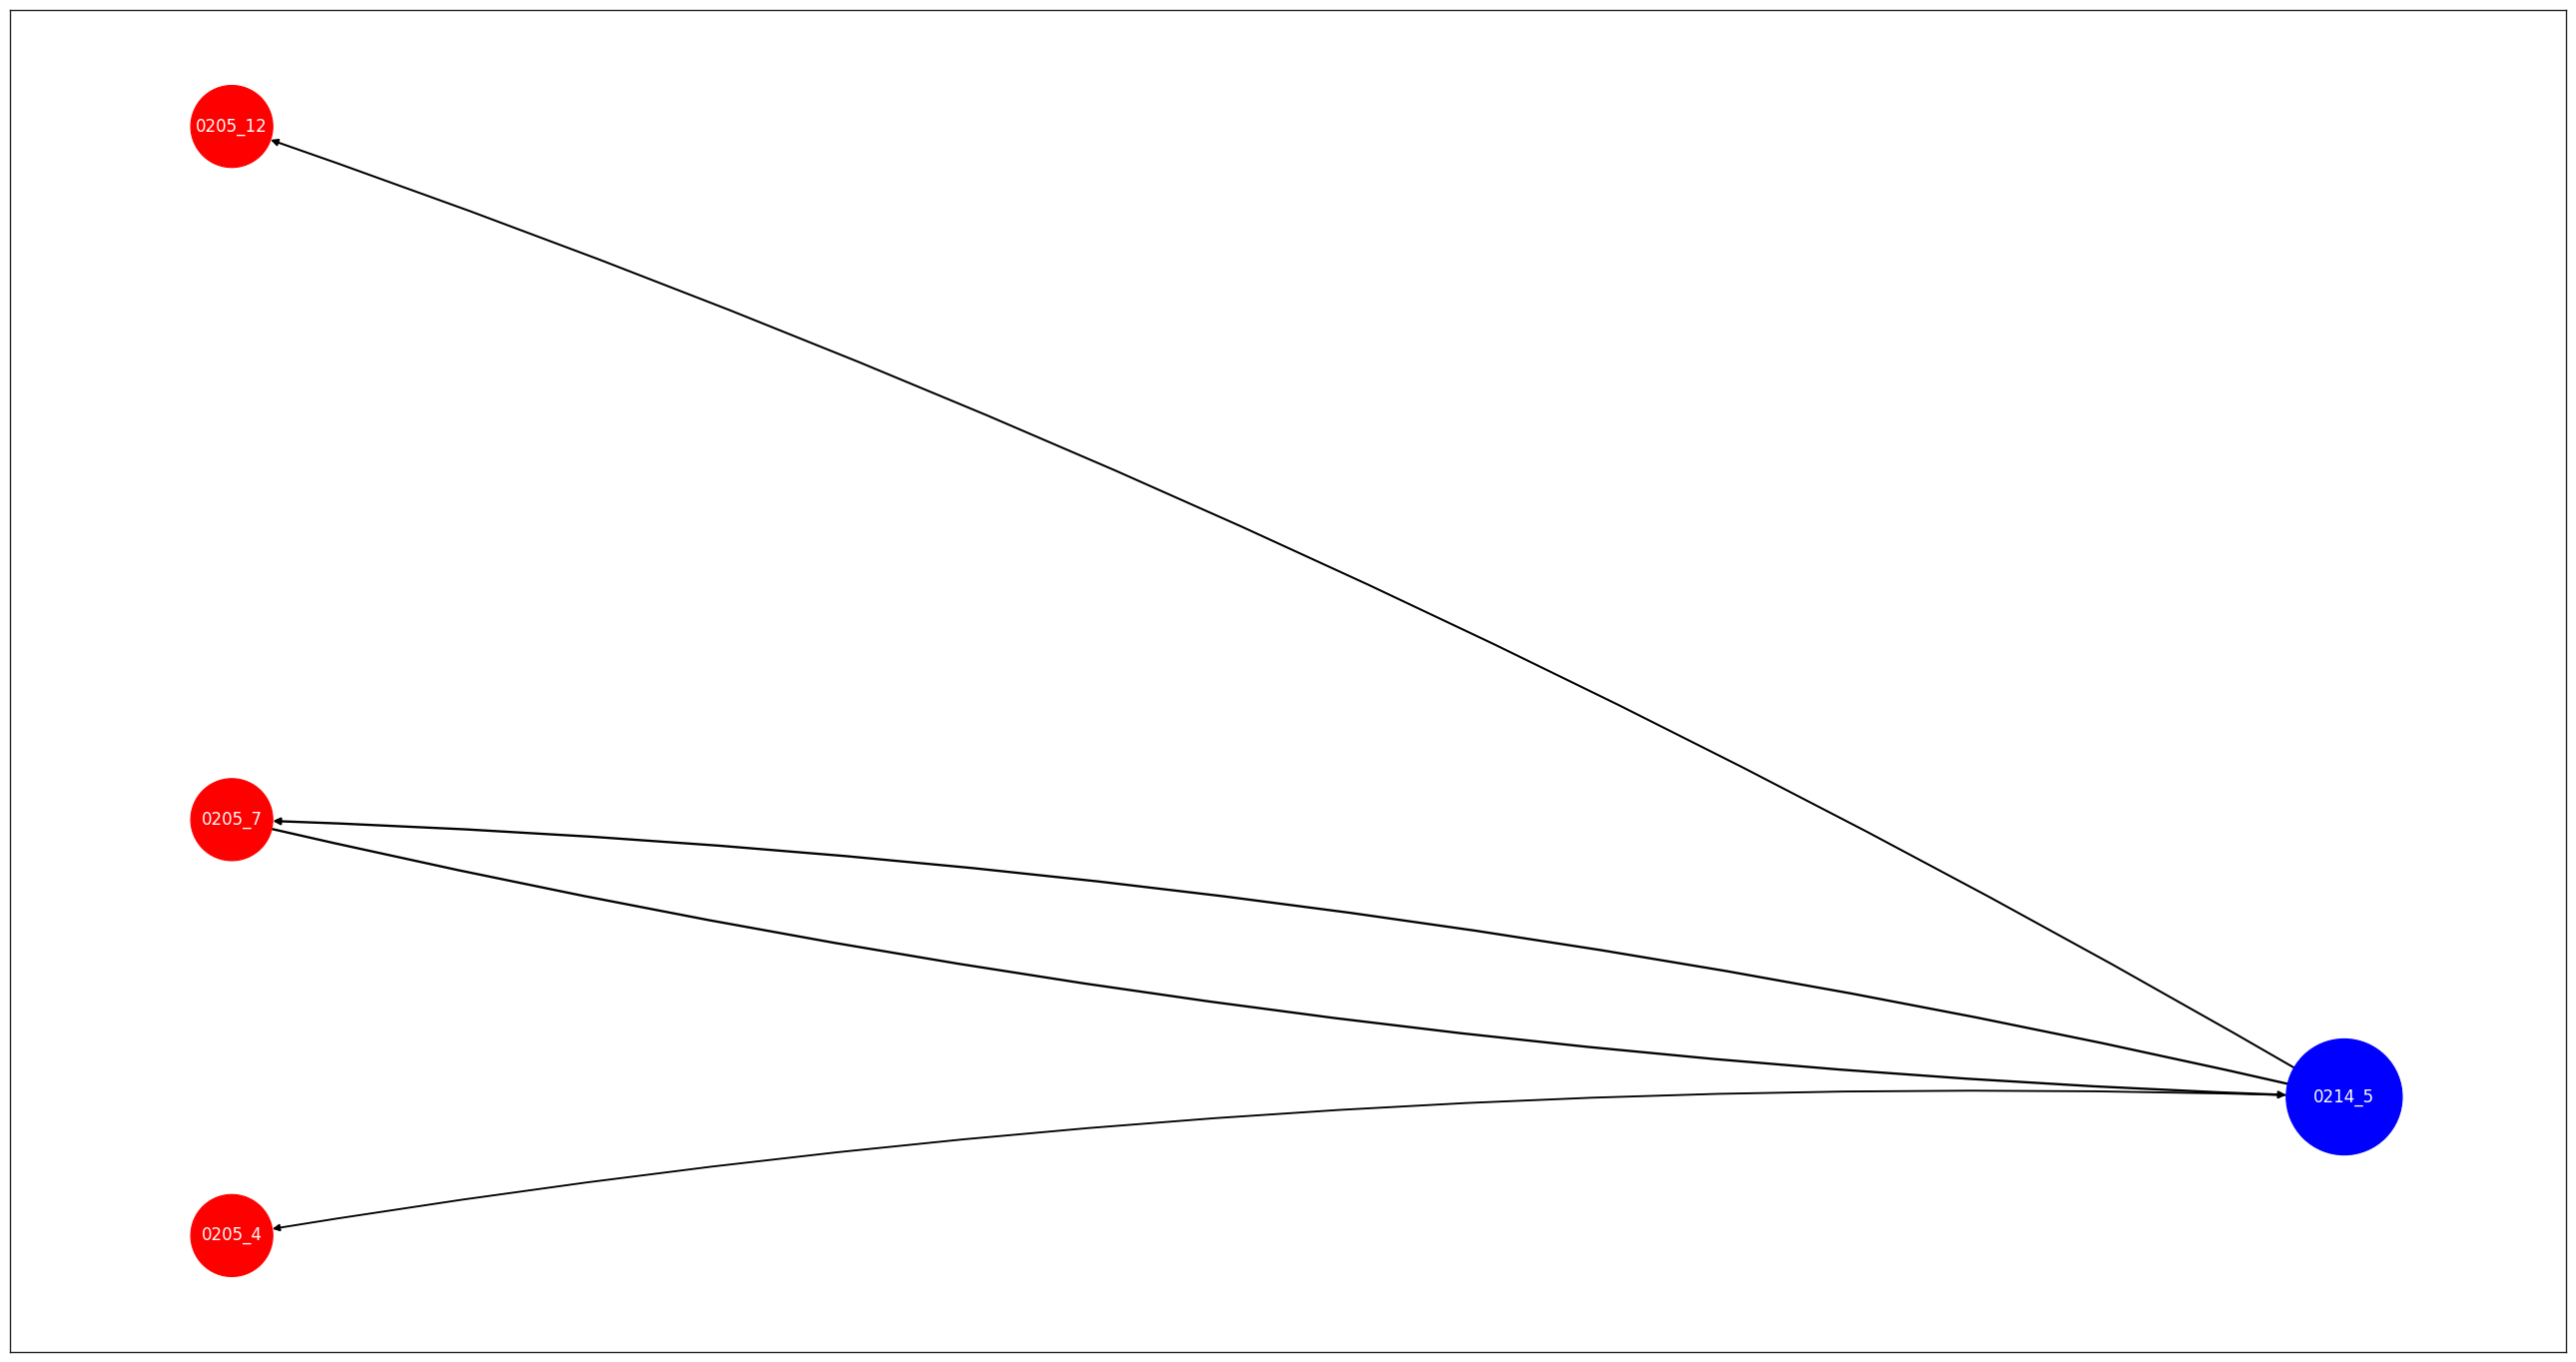

[5, 20, 0, 22]
{5: (0, 14), 20: (0, 24), 0: (0, 8), 22: (1, 32)}


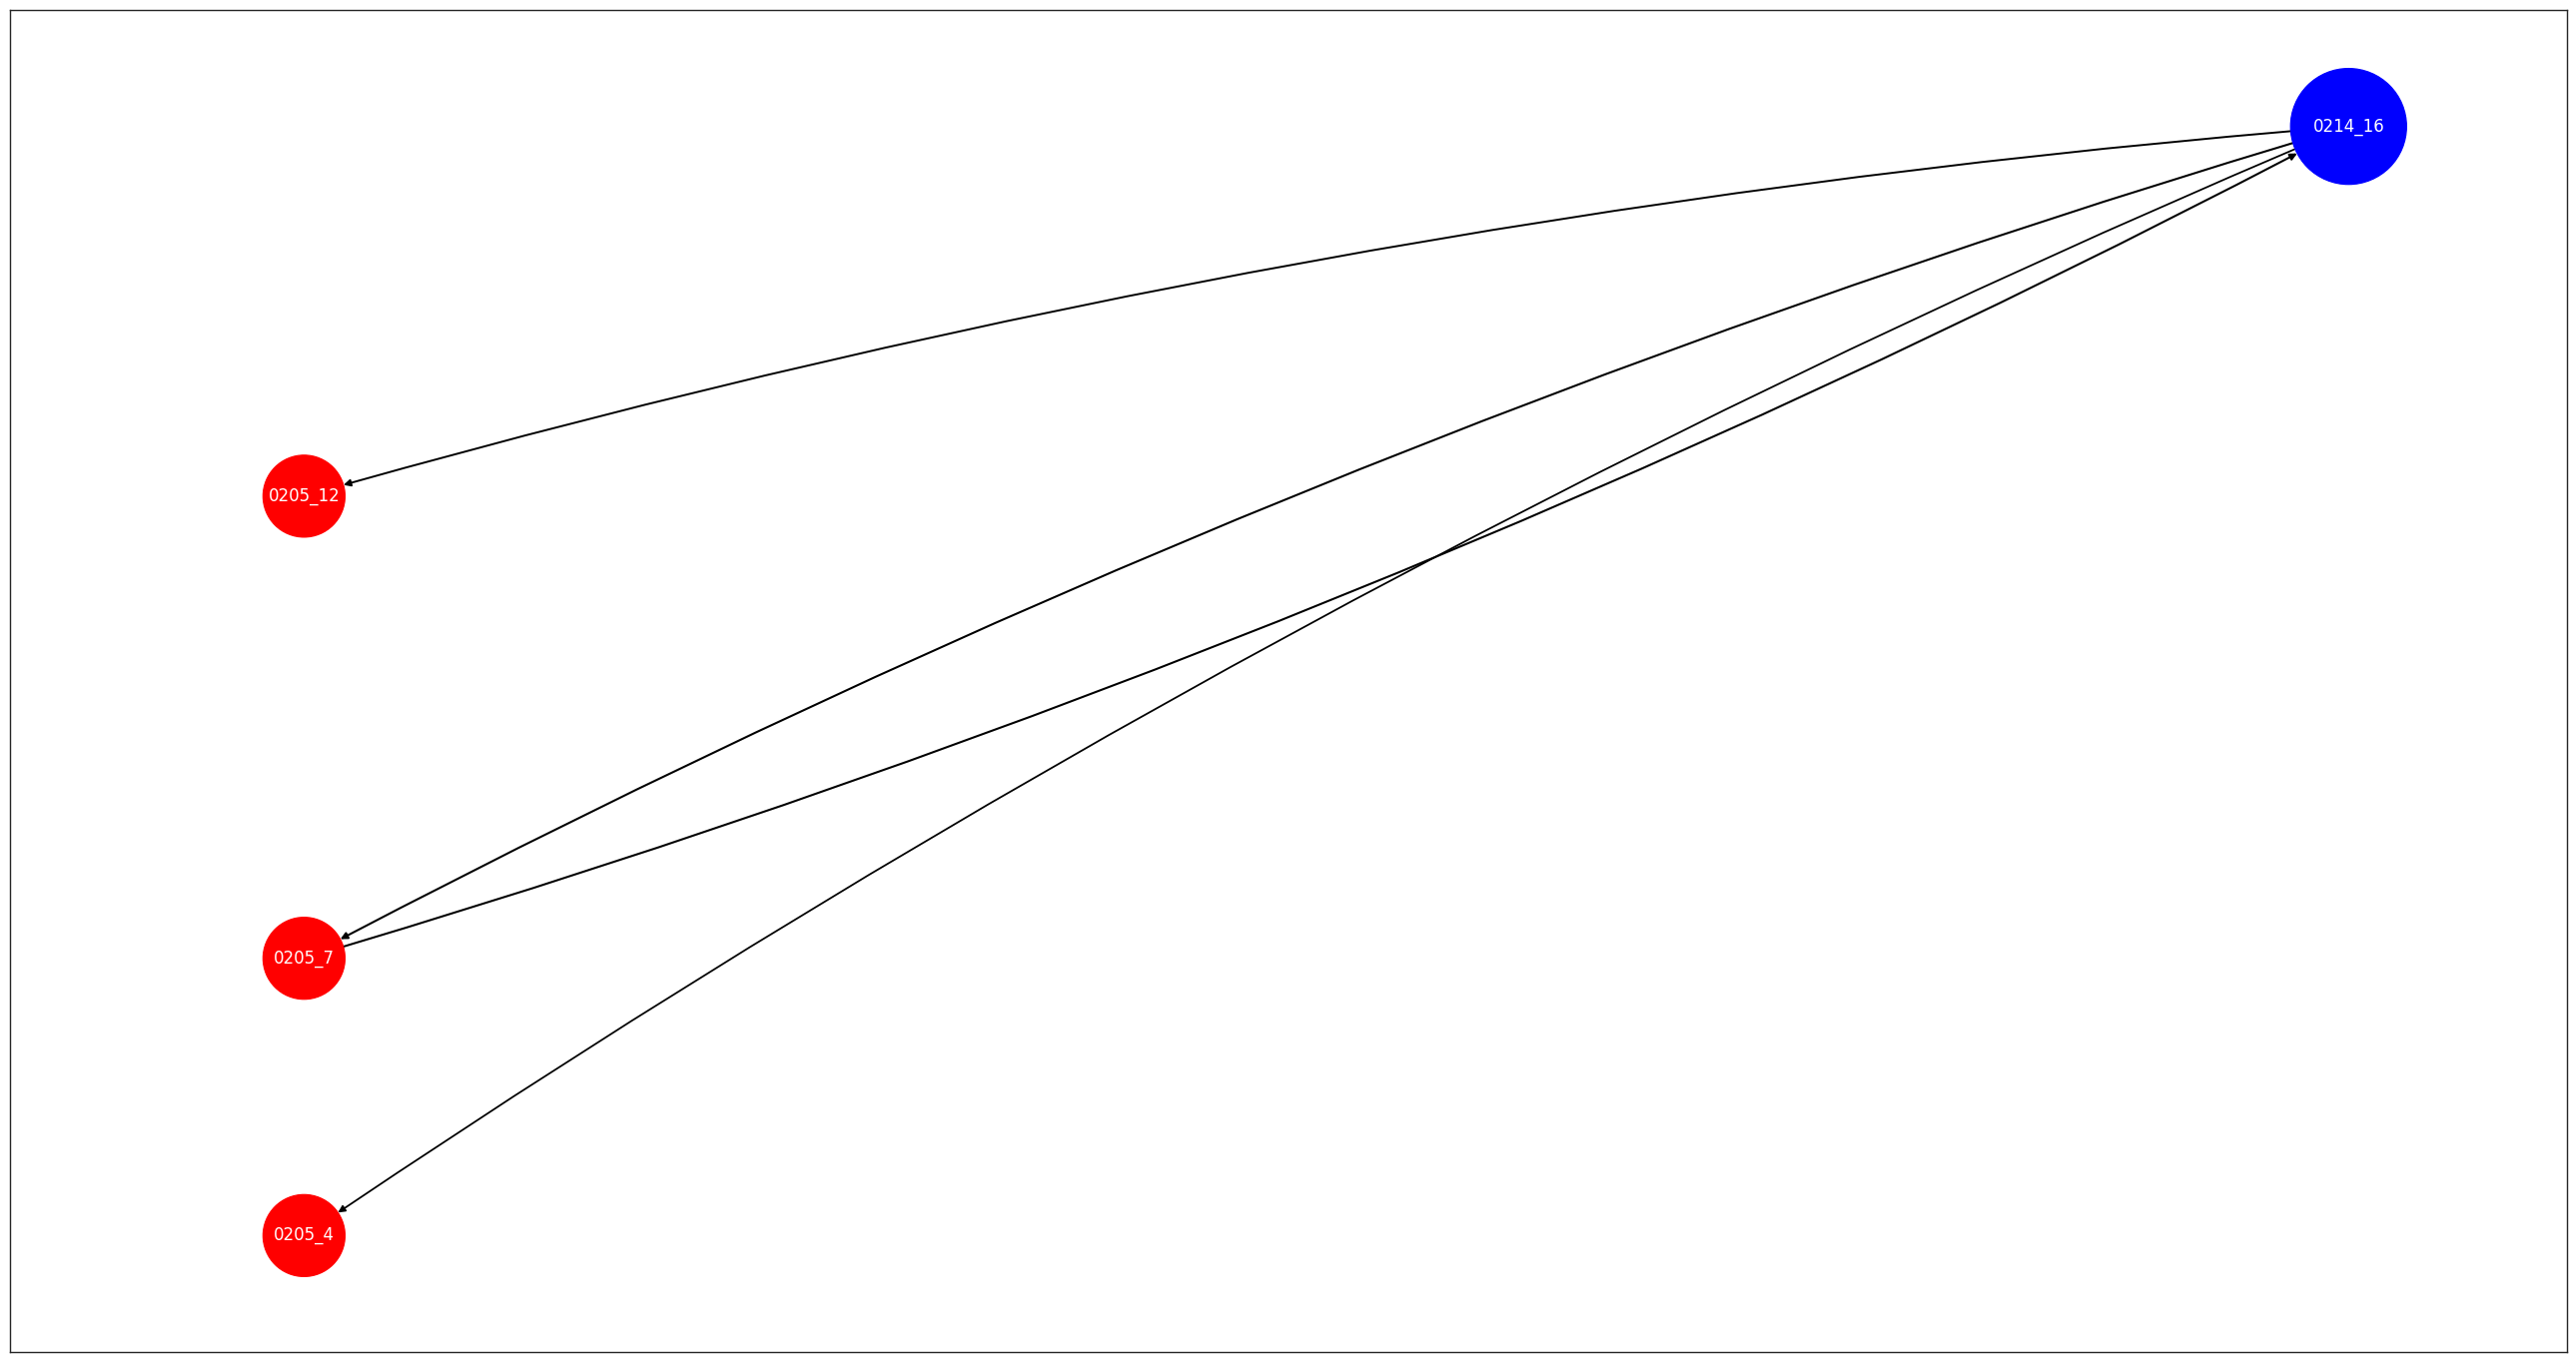

[20, 10, 5, 27]
{20: (0, 24), 10: (0, 0), 5: (0, 14), 27: (1, 4)}


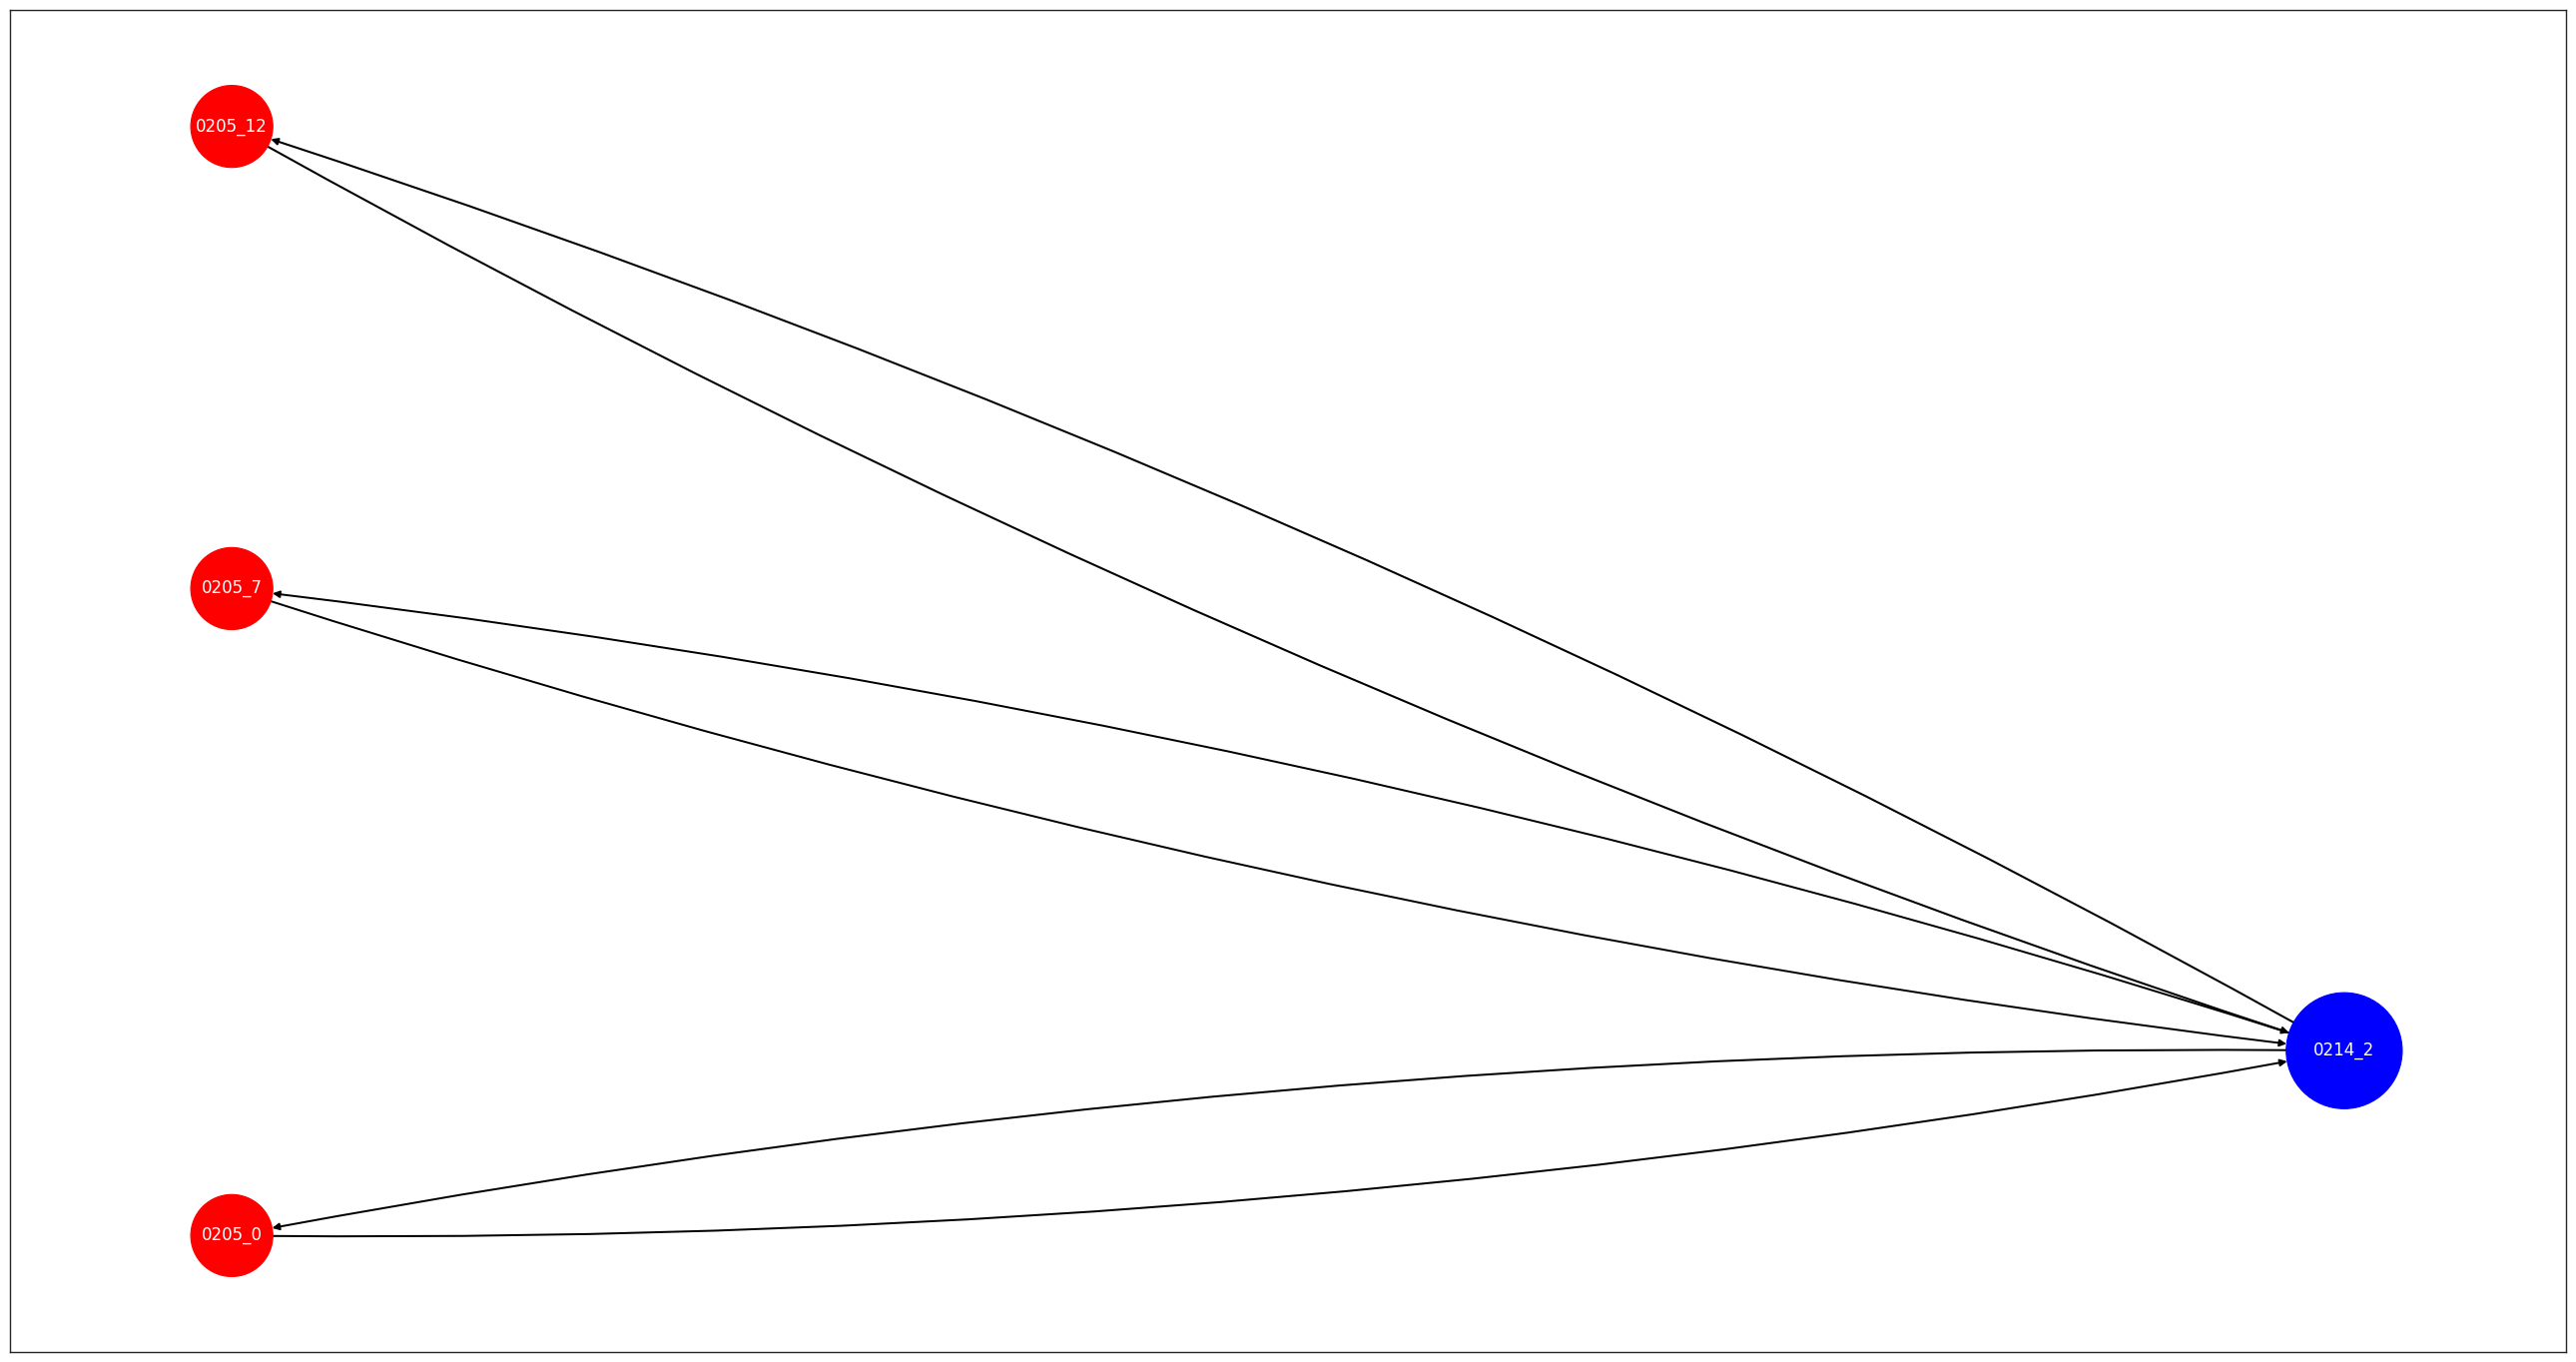

In [267]:
drawnodegraph(G, node_ids[5])
drawnodegraph(G, node_ids[16])
drawnodegraph(G, node_ids[22])
drawnodegraph(G, node_ids[27])

[8, 1, 21]
{8: (1, 2), 1: (1, 12), 21: (0, 28)}


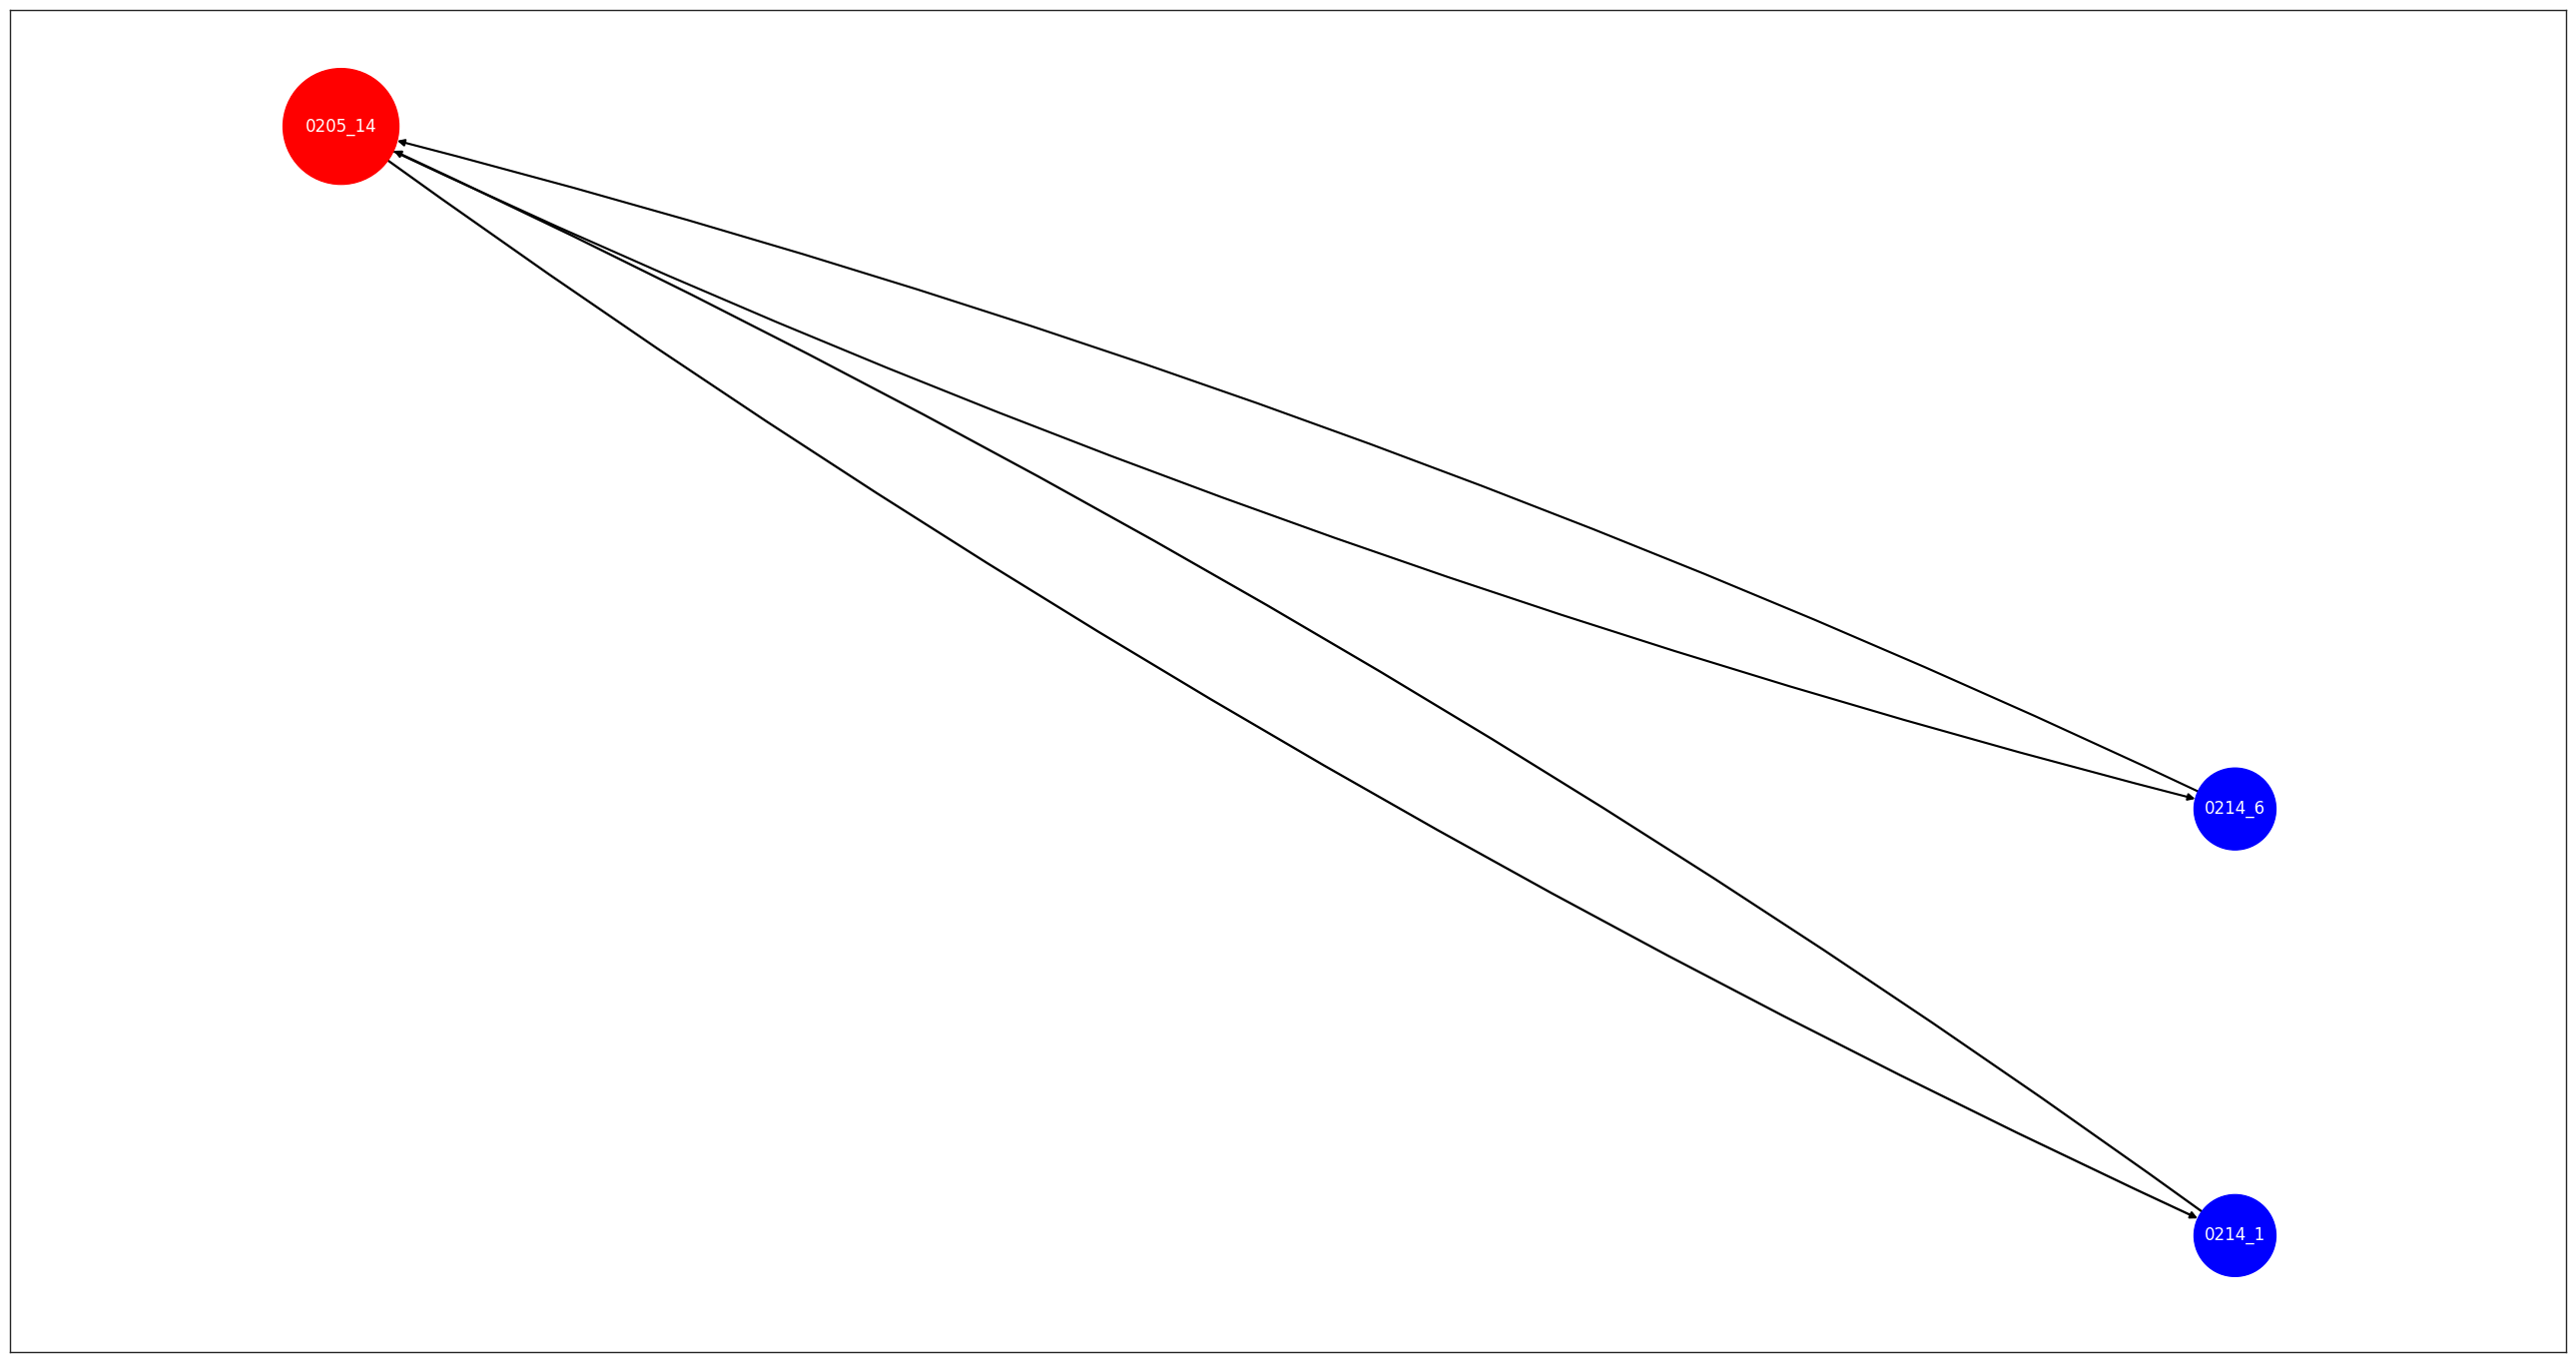

In [253]:
drawnodegraph(G, node_ids[21])

# Write algorithm for densest subnet of given size 5 in this case.

In [ ]:
# create a graph with networkx
collect all nodes

In [58]:
session_matches['0205']['0214']

[('0205_0', '0214_4', 0.20961929766178247),
 ('0205_0', '0214_18', 0.24564780781191614),
 ('0205_0', '0214_2', 0.2819798935261926),
 ('0205_1', '0214_7', 0.13621133818250933),
 ('0205_1', '0214_0', 0.16039767167393368),
 ('0205_1', '0214_25', 0.22624613617012823),
 ('0205_2', '0214_4', 0.20949621758568965),
 ('0205_2', '0214_18', 0.23885773647149605),
 ('0205_2', '0214_14', 0.2630184629846852),
 ('0205_3', '0214_12', 0.26428248235355245),
 ('0205_3', '0214_8', 0.285658299740555),
 ('0205_3', '0214_7', 0.2948540266511926),
 ('0205_4', '0214_14', 0.22249791092316706),
 ('0205_4', '0214_4', 0.2623973716488921),
 ('0205_4', '0214_11', 0.2709100604937835),
 ('0205_5', '0214_10', 0.31112710068807514),
 ('0205_5', '0214_1', 0.3246968270063238),
 ('0205_5', '0214_8', 0.3893030099608285),
 ('0205_6', '0214_10', 0.19920273558185536),
 ('0205_6', '0214_8', 0.28134137199191767),
 ('0205_6', '0214_7', 0.2816964108603105),
 ('0205_7', '0214_5', 0.15917153448264731),
 ('0205_7', '0214_16', 0.26329110

In [59]:
session_matches['0228']['0214']

[('0228_0', '0214_2', 0.18417850071722267),
 ('0228_0', '0214_5', 0.19898259516519562),
 ('0228_0', '0214_3', 0.19903588544157258),
 ('0228_1', '0214_9', 0.22131219797793933),
 ('0228_1', '0214_24', 0.2229080094739838),
 ('0228_1', '0214_25', 0.24536967707376553),
 ('0228_2', '0214_17', 0.18498847712635835),
 ('0228_2', '0214_9', 0.22025745069168953),
 ('0228_2', '0214_25', 0.26703315442855546),
 ('0228_3', '0214_7', 0.19543378531147554),
 ('0228_3', '0214_12', 0.2302919692558444),
 ('0228_3', '0214_8', 0.2378229594685946),
 ('0228_4', '0214_0', 0.2057039190784001),
 ('0228_4', '0214_7', 0.20713285971036732),
 ('0228_4', '0214_18', 0.25386915090978596),
 ('0228_5', '0214_1', 0.20229342696464264),
 ('0228_5', '0214_6', 0.25057737862138996),
 ('0228_5', '0214_8', 0.2642144514735784),
 ('0228_6', '0214_20', 0.2515020428199888),
 ('0228_6', '0214_4', 0.33305747608969194),
 ('0228_6', '0214_6', 0.3331782264485999),
 ('0228_7', '0214_3', 0.16173443938030885),
 ('0228_7', '0214_2', 0.18390603

In [37]:
session_matches['0214']['0228']

[('0214_0', '0228_15', 0.1563210032576205),
 ('0214_0', '0228_4', 0.2057039190784001),
 ('0214_1', '0228_9', 0.17047505784121272),
 ('0214_1', '0228_5', 0.20229342696464264),
 ('0214_2', '0228_7', 0.18390603354255738),
 ('0214_2', '0228_0', 0.18417850071722267),
 ('0214_3', '0228_7', 0.16173443938030885),
 ('0214_3', '0228_0', 0.19903588544157258),
 ('0214_4', '0228_27', 0.17392556227857822),
 ('0214_4', '0228_11', 0.22115956249252505),
 ('0214_5', '0228_0', 0.19898259516519562),
 ('0214_5', '0228_7', 0.2621703804558638),
 ('0214_6', '0228_5', 0.25057737862138996),
 ('0214_6', '0228_27', 0.27818543847837035),
 ('0214_7', '0228_20', 0.16494487926273224),
 ('0214_7', '0228_15', 0.17230500454512618),
 ('0214_8', '0228_12', 0.21157309365455243),
 ('0214_8', '0228_3', 0.2378229594685946),
 ('0214_9', '0228_2', 0.22025745069168953),
 ('0214_9', '0228_1', 0.22131219797793933),
 ('0214_10', '0228_9', 0.18858006650446515),
 ('0214_10', '0228_28', 0.23131141303780703),
 ('0214_11', '0228_7', 0.2

# Method 1: Sort in face sizes, select best of three based on least face_size differences.

In [9]:
MATCH_THRESHOLD=0.3
final_matches = []
for (sessionA, sessionB) in product(sorted(sessions), sorted(sessions)):
    sessionA_key, sessionB_key = sessionA.split("_")[-1][4:8], sessionB.split("_")[-1][4:8]
    if not (sessionA==sessionB):
        # if sessionA not in session_matches:
        # match session A and session B based on gaze clustering
        match_scores_gaze = {}
        match_scores_clu  = {}
        for idA,idB in product(course_input_dict[sessionA].keys(), course_input_dict[sessionB].keys()):
            
            gaze_embA, gaze_embB = course_input_dict[sessionA][idA]['gaze_emb'], course_input_dict[sessionB][idB]['gaze_emb']                
            clu_embA, clu_embB = course_input_dict[sessionA][idA]['cluster_emb'], course_input_dict[sessionB][idB]['cluster_emb']                
            
            if idA not in match_scores_gaze:
                match_scores_gaze[idA] = {}
            if idA not in match_scores_clu:
                match_scores_clu[idA] = {}
                
            if gaze_embA is None or gaze_embB is None:
                match_scores_gaze[idA][idB] = np.inf
            else:
                match_distance = cdist(gaze_embA.reshape(1,-1), gaze_embB.reshape(1,-1))[0][0]
                match_scores_gaze[idA][idB] = match_distance

            if clu_embA is None or clu_embB is None:
                match_scores_clu[idA][idB] = np.inf
            else:
                match_distance = cdist(clu_embA.reshape(1,-1), clu_embB.reshape(1,-1))[0][0]
                match_scores_clu[idA][idB] = match_distance
        
        df_match_gaze = pd.DataFrame(match_scores_gaze) 
        df_match_clu = pd.DataFrame(match_scores_clu) 
        gaze_cols = df_match_gaze.columns.values.tolist()
        clu_cols = df_match_clu.columns.values.tolist()
        all_cols = np.unique(gaze_cols+clu_cols)
        for col in all_cols:
            if col not in df_match_clu.columns:
                df_match_clu[col] = np.inf
            if col not in df_match_gaze.columns:
                df_match_clu[col] = np.inf
            sessionB_matches = deepcopy(df_match_clu[col]).sort_values().head(3).index.values.tolist() + \
                                deepcopy(df_match_gaze[col]).sort_values().head(3).index.values.tolist()
            sessionB_matches = np.unique(sessionB_matches)
            for match_id in sessionB_matches:
                if (match_scores_clu[col][match_id]<MATCH_THRESHOLD) & (match_scores_gaze[col][match_id]<MATCH_THRESHOLD):
                    col_face_area = course_input_dict[sessionA][col]['face_width_med'] * course_input_dict[sessionA][col]['face_height_med']
                    match_face_area = course_input_dict[sessionB][match_id]['face_width_med'] * course_input_dict[sessionB][match_id]['face_height_med']
                    rel_diff = np.abs(col_face_area-match_face_area)*100/min(col_face_area,match_face_area)
                    final_matches.append((sessionA_key, sessionB_key, f'{sessionA_key}_{col}', f'{sessionB_key}_{match_id}', match_scores_gaze[col][match_id], match_scores_clu[col][match_id], col_face_area, match_face_area))

In [10]:
df_final_matches = pd.DataFrame(final_matches, columns=['sessionA','sessionB','idA','idB','match_score_gaze','match_score_clu','face_areaA','face_areaB'])
df_final_matches

,sessionA,sessionB,idA,idB,match_score_gaze,match_score_clu,face_areaA,face_areaB
0,0205,0214,0205_0,0214_4,0.209619,0.190164,2937.688721,2717.034668
1,0205,0214,0205_0,0214_18,0.245648,0.184679,2937.688721,3237.280029
2,0205,0214,0205_1,0214_0,0.160398,0.133073,4904.356445,4900.709473
3,0205,0214,0205_1,0214_7,0.136211,0.169369,4904.356445,6079.827148
4,0205,0214,0205_1,0214_25,0.226246,0.218051,4904.356445,10237.457031
...,...,...,...,...,...,...,...,...
778,0402,0307,0402_13,0307_5,0.254316,0.246751,2208.724609,3252.738281
779,0402,0307,0402_13,0307_7,0.289207,0.240926,2208.724609,5734.752441
780,0402,0307,0402_13,0307_9,0.240351,0.287552,2208.724609,3080.806641
781,0402,0307,0402_14,0307_6,0.220349,0.215992,6910.056152,6387.147949


In [11]:
df_final_matches[df_final_matches.idA=='0205_7'].sort_values(by='match_score_gaze')

,sessionA,sessionB,idA,idB,match_score_gaze,match_score_clu,face_areaA,face_areaB
17,0205,0214,0205_7,0214_5,0.159172,0.126402,2280.500732,2324.556641
66,0205,0228,0205_7,0228_0,0.188558,0.139466,2280.500732,2484.618896
67,0205,0228,0205_7,0228_7,0.278805,0.260282,2280.500732,2865.228027
16,0205,0214,0205_7,0214_2,0.290655,0.242585,2280.500732,2567.703857


In [12]:
s1,s2 = '0205','0214'


In [13]:
df_pair_matches =df_final_matches
# df_pair_matches

In [14]:
df_pair_matches = df_pair_matches.sort_values(by=['face_areaA','face_areaB'],ascending=False)
df_pair_matches['area_diff'] = np.abs(df_pair_matches['face_areaA'] - df_pair_matches['face_areaB'])*100/np.minimum(df_pair_matches['face_areaA'],df_pair_matches['face_areaB'])
df_pair_matches.sort_values(by='idB')

,sessionA,sessionB,idA,idB,match_score_gaze,match_score_clu,face_areaA,face_areaB,area_diff
569,0307,0205,0307_14,0205_0,0.284620,0.260356,4850.437988,2937.688721,65.110687
173,0214,0205,0214_4,0205_0,0.209619,0.190164,2717.034668,2937.688721,8.121136
555,0307,0205,0307_7,0205_0,0.274459,0.216555,5734.752441,2937.688721,95.213074
567,0307,0205,0307_13,0205_0,0.272068,0.288607,3120.920166,2937.688721,6.237266
367,0228,0205,0228_8,0205_0,0.154215,0.124304,3667.576904,2937.688721,24.845661
...,...,...,...,...,...,...,...,...,...
322,0214,0402,0214_4,0402_8,0.218454,0.183167,2717.034668,2994.842041,10.224653
514,0228,0402,0228_4,0402_8,0.285323,0.254541,4504.681152,2994.842041,50.414646
161,0205,0402,0205_16,0402_8,0.281002,0.250209,4545.930176,2994.842041,51.791985
524,0228,0402,0228_12,0402_8,0.241196,0.238448,3218.271973,2994.842041,7.460491


In [15]:
df_pair_matches[(df_pair_matches.match_score_gaze<0.2) & (df_pair_matches.match_score_clu<0.2) & (df_pair_matches.area_diff<20) & (np.minimum(df_pair_matches.face_areaA, df_pair_matches.face_areaB)>np.median(df_pair_matches.face_areaA))]


,sessionA,sessionB,idA,idB,match_score_gaze,match_score_clu,face_areaA,face_areaB,area_diff
546,0307,0205,0307_3,0205_11,0.175597,0.174919,6953.412598,6854.993164,1.435734
545,0307,0205,0307_3,0205_9,0.192384,0.154563,6953.412598,6726.498047,3.373443
581,0307,0214,0307_3,0214_9,0.122391,0.097471,6953.412598,6313.525391,10.135180
123,0205,0307,0205_11,0307_3,0.175597,0.174919,6854.993164,6953.412598,1.435734
117,0205,0307,0205_9,0307_3,0.192384,0.154563,6726.498047,6953.412598,3.373443
23,0205,0214,0205_9,0214_9,0.192321,0.199069,6726.498047,6313.525391,6.541079
299,0214,0307,0214_9,0307_3,0.122391,0.097471,6313.525391,6953.412598,10.135180
187,0214,0205,0214_9,0205_9,0.192321,0.199069,6313.525391,6726.498047,6.541079
120,0205,0307,0205_10,0307_7,0.196396,0.148322,6251.166992,5734.752441,9.005001
293,0214,0307,0214_7,0307_7,0.191758,0.187516,6079.827148,5734.752441,6.017255


In [16]:
id_matches = {}
matched_idA, matched_idB = [],[]

In [269]:
best_match_1 = df_pair_matches[(df_pair_matches.match_score_gaze<0.2) & 
                                (df_pair_matches.match_score_clu<0.2) & 
                                (df_pair_matches.area_diff<20) & 
                                (np.minimum(df_pair_matches.face_areaA, df_pair_matches.face_areaB)>np.median(df_pair_matches.face_areaA))
                                ].sort_values(by='match_score_gaze')
sprint(best_match_1)
for idx,row in best_match_1.iterrows():
    if row['idA'] in matched_idA:
        continue
    elif row['idB'] in matched_idB:
        continue
    else:
        id_matches[row['idA']] = row['idB']
        matched_idA.append(row['idA'])
        matched_idB.append(row['idB'])
df_next_matches = df_pair_matches[(~df_pair_matches.idA.isin(matched_idA)) & (~df_pair_matches.idB.isin(matched_idB))]
id_matches

best_match_1 :     sessionA sessionB      idA      idB  match_score_gaze  match_score_clu  \
52      0205     0228   0205_1  0228_15          0.091586         0.117473   
385     0228     0205  0228_15   0205_1          0.091586         0.117473   
581     0307     0214   0307_3   0214_9          0.122391         0.097471   
299     0214     0307   0214_9   0307_3          0.122391         0.097471   
355     0228     0205   0228_4   0205_1          0.130837         0.149485   
49      0205     0228   0205_1   0228_4          0.130837         0.149485   
445     0228     0214  0228_15   0214_0          0.156321         0.199157   
215     0214     0228   0214_0  0228_15          0.156321         0.199157   
164     0214     0205   0214_0   0205_1          0.160398         0.133073   
2       0205     0214   0205_1   0214_0          0.160398         0.133073   
546     0307     0205   0307_3  0205_11          0.175597         0.174919   
123     0205     0307  0205_11   0307_3          

{'0205_1': '0228_15',
 '0228_15': '0205_1',
 '0307_3': '0214_9',
 '0214_9': '0307_3',
 '0307_7': '0214_7',
 '0214_7': '0307_7'}

In [270]:
df_next_matches = pd.merge(df_next_matches, df_next_matches.groupby('idA',as_index=False)['idB'].count(), on='idA',suffixes=('','_count'))
df_next_matches

,sessionA,sessionB,idA,idB,match_score_gaze,match_score_clu,face_areaA,face_areaB,area_diff,idB_count
0,0214,0228,0214_23,0228_16,0.276999,0.265480,16655.488281,6652.971680,150.346603,5
1,0214,0228,0214_23,0228_20,0.276548,0.295160,16655.488281,6609.685059,151.986099,5
2,0214,0228,0214_23,0228_1,0.254470,0.253439,16655.488281,6070.220703,174.380280,5
3,0214,0402,0214_23,0402_31,0.246010,0.244747,16655.488281,5959.022461,179.500351,5
4,0214,0402,0214_23,0402_3,0.252986,0.262621,16655.488281,4972.325195,234.963760,5
...,...,...,...,...,...,...,...,...,...,...
628,0402,0205,0402_13,0205_0,0.140296,0.144655,2208.724609,2937.688721,33.003849,14
629,0402,0214,0402_13,0214_6,0.295788,0.238401,2208.724609,2896.570312,31.142212,14
630,0402,0214,0402_13,0214_4,0.207464,0.209948,2208.724609,2717.034668,23.013737,14
631,0214,0228,0214_16,0228_7,0.286411,0.268705,2003.554077,2865.228027,43.007275,2


In [271]:
df_single_matches = df_next_matches[df_next_matches.idB_count<=1]
best_match_2 = df_single_matches[(df_single_matches.match_score_gaze<0.25) & 
                                (df_single_matches.match_score_clu<0.25) & 
                                (df_single_matches.area_diff<20) & 
                                (np.minimum(df_single_matches.face_areaA, df_single_matches.face_areaB)>np.median(df_pair_matches.face_areaA))
                                ].sort_values(by='match_score_gaze')
sprint(best_match_2)
for idx,row in best_match_2.iterrows():
    if row['idA'] in matched_idA:
        continue
    elif row['idB'] in matched_idB:
        continue
    else:
        id_matches[row['idA']] = row['idB']
        matched_idA.append(row['idA'])
        matched_idB.append(row['idB'])
df_next_matches = df_pair_matches[(~df_pair_matches.idA.isin(matched_idA)) & (~df_pair_matches.idB.isin(matched_idB))]
id_matches

best_match_2 :     sessionA sessionB     idA     idB  match_score_gaze  match_score_clu  \
159     0402     0214  0402_1  0214_0          0.229565         0.238152   

     face_areaA   face_areaB  area_diff  idB_count  
159  4969.29541  4900.709473    1.39951          1  


{'0205_1': '0228_15',
 '0228_15': '0205_1',
 '0307_3': '0214_9',
 '0214_9': '0307_3',
 '0307_7': '0214_7',
 '0214_7': '0307_7',
 '0402_1': '0214_0'}

In [272]:
df_next_matches = pd.merge(df_next_matches, df_next_matches.groupby('idB',as_index=False)['idA'].count(), on='idB',suffixes=('','_count'))
df_next_matches

,sessionA,sessionB,idA,idB,match_score_gaze,match_score_clu,face_areaA,face_areaB,area_diff,idA_count
0,0214,0228,0214_23,0228_16,0.276999,0.265480,16655.488281,6652.971680,150.346603,6
1,0214,0228,0214_25,0228_16,0.244440,0.188577,10237.457031,6652.971680,53.877960,6
2,0205,0228,0205_8,0228_16,0.262250,0.241959,6476.984863,6652.971680,2.717110,6
3,0402,0228,0402_31,0228_16,0.246560,0.219877,5959.022461,6652.971680,11.645353,6
4,0402,0228,0402_22,0228_16,0.234745,0.286439,5731.761230,6652.971680,16.072031,6
...,...,...,...,...,...,...,...,...,...,...
621,0214,0205,0214_5,0205_7,0.159172,0.126402,2324.556641,2280.500732,1.931852,4
622,0205,0214,0205_12,0214_5,0.273487,0.200659,2641.500244,2324.556641,13.634583,3
623,0228,0214,0228_0,0214_5,0.198983,0.161936,2484.618896,2324.556641,6.885711,3
624,0205,0214,0205_7,0214_5,0.159172,0.126402,2280.500732,2324.556641,1.931852,3


In [273]:
best_match_3 = df_next_matches[(df_next_matches.idA_count<=1) & 
                                (df_next_matches.area_diff<20)].sort_values(by='match_score_gaze')
sprint(best_match_3)
for idx,row in best_match_3.iterrows():
    if row['idA'] in matched_idA:
        continue
    elif row['idB'] in matched_idB:
        continue
    else:
        id_matches[row['idA']] = row['idB']
        matched_idA.append(row['idA'])
        matched_idB.append(row['idB'])
        

best_match_3 :     sessionA sessionB     idA      idB  match_score_gaze  match_score_clu  \
454     0214     0402  0214_0   0402_1          0.229565         0.238152   
65      0228     0214  0228_6  0214_20          0.251502         0.196906   

       face_areaA    face_areaB  area_diff  idA_count  
454   4900.709473   4969.295410   1.399510          1  
65   11118.146484  10518.415039   5.701728          1  


In [274]:
df_next_matches = df_pair_matches[(~df_pair_matches.idA.isin(matched_idA)) & (~df_pair_matches.idB.isin(matched_idB))]
id_matches

{'0205_1': '0228_15',
 '0228_15': '0205_1',
 '0307_3': '0214_9',
 '0214_9': '0307_3',
 '0307_7': '0214_7',
 '0214_7': '0307_7',
 '0402_1': '0214_0',
 '0214_0': '0402_1',
 '0228_6': '0214_20'}

In [275]:
df_next_matches = pd.merge(df_next_matches, df_next_matches.groupby('idB',as_index=False)['idA'].count(), on='idB',suffixes=('','_count'))
df_next_matches = pd.merge(df_next_matches, df_next_matches.groupby('idA',as_index=False)['idB'].count(), on='idA',suffixes=('','_count'))
df_next_matches.sort_values(by='idA_count')

,sessionA,sessionB,idA,idB,match_score_gaze,match_score_clu,face_areaA,face_areaB,area_diff,idA_count,idB_count
78,0402,0214,0402_3,0214_22,0.230249,0.239910,4972.325195,8123.776367,63.379829,1,5
525,0307,0228,0307_23,0228_26,0.237897,0.291154,5998.303711,4626.680176,29.645956,1,5
581,0214,0205,0214_14,0205_19,0.285941,0.283317,2281.529297,4156.024414,82.159592,1,10
67,0307,0402,0307_6,0402_14,0.220349,0.215992,6387.147949,6910.056152,8.186881,1,10
21,0205,0402,0205_8,0402_0,0.281650,0.234297,6476.984863,4301.353516,50.580158,1,9
...,...,...,...,...,...,...,...,...,...,...,...
232,0307,0402,0307_17,0402_8,0.189124,0.188986,3144.698975,2994.842041,5.003834,23,12
223,0228,0402,0228_12,0402_8,0.241196,0.238448,3218.271973,2994.842041,7.460491,23,9
318,0214,0402,0214_4,0402_8,0.218454,0.183167,2717.034668,2994.842041,10.224653,23,12
266,0228,0402,0228_27,0402_8,0.257875,0.227310,3070.659424,2994.842041,2.531599,23,12


In [276]:
df_next_matches = pd.merge(df_next_matches, df_next_matches.groupby('idA',as_index=False).agg({'match_score_gaze':lambda x: 1.0 if (len(x)<2) else sorted(x)[1]-sorted(x)[0]}), on='idA',suffixes=('','_best_diff'))

In [277]:
df_next_matches = pd.merge(df_next_matches, df_next_matches.groupby('idA',as_index=False).agg({'match_score_gaze':lambda x: sorted(x)[0]}), on='idA',suffixes=('','_min_match'))



In [278]:
best_match_3 = df_next_matches[(df_next_matches.match_score_gaze<0.2) &
                (df_next_matches.match_score_gaze_best_diff>0.05) &
                (df_next_matches.match_score_gaze==df_next_matches.match_score_gaze_min_match)].sort_values(by='match_score_gaze')
sprint(best_match_3)
for idx,row in best_match_3.iterrows():
    if row['idA'] in matched_idA:
        continue
    elif row['idB'] in matched_idB:
        continue
    else:
        id_matches[row['idA']] = row['idB']
        matched_idA.append(row['idA'])
        matched_idB.append(row['idB'])
        


best_match_3 :     sessionA sessionB      idA      idB  match_score_gaze  match_score_clu  \
521     0307     0228  0307_23  0228_21          0.130345         0.204489   
495     0307     0214   0307_8   0214_6          0.134720         0.123442   
41      0214     0228  0214_12  0228_20          0.140899         0.220827   
93      0228     0214  0228_20  0214_12          0.140899         0.220827   
370     0307     0228  0307_10  0228_21          0.149920         0.145098   
98      0214     0228  0214_17   0228_2          0.184988         0.188073   

      face_areaA   face_areaB  area_diff  idA_count  idB_count  \
521  5998.303711  4222.622559  42.051617          4          5   
495  3218.191650  2896.570312  11.103522         12          7   
41   6785.166016  6609.685059   2.654907          7          9   
93   6609.685059  6785.166016   2.654907          7          6   
370  6114.787598  4222.622559  44.810184          4          5   
98   6365.938965  3891.798340  63.573196  

In [279]:
df_next_matches = df_pair_matches[(~df_pair_matches.idA.isin(matched_idA)) & (~df_pair_matches.idB.isin(matched_idB))]
id_matches

{'0205_1': '0228_15',
 '0228_15': '0205_1',
 '0307_3': '0214_9',
 '0214_9': '0307_3',
 '0307_7': '0214_7',
 '0214_7': '0307_7',
 '0402_1': '0214_0',
 '0214_0': '0402_1',
 '0228_6': '0214_20',
 '0307_23': '0228_21',
 '0307_8': '0214_6',
 '0214_12': '0228_20',
 '0228_20': '0214_12',
 '0214_17': '0228_2'}

In [280]:
df_next_matches = df_next_matches[np.abs(df_next_matches['match_score_gaze']-df_next_matches['match_score_clu'])<0.05]
df_next_matches = pd.merge(df_next_matches, df_next_matches.groupby('idB',as_index=False)['idA'].count(), on='idB',suffixes=('','_count'))
df_next_matches = pd.merge(df_next_matches, df_next_matches.groupby('idA',as_index=False)['idB'].count(), on='idA',suffixes=('','_count'))
df_next_matches

,sessionA,sessionB,idA,idB,match_score_gaze,match_score_clu,face_areaA,face_areaB,area_diff,idA_count,idB_count
0,0214,0228,0214_23,0228_16,0.276999,0.265480,16655.488281,6652.971680,150.346603,4,4
1,0214,0228,0214_23,0228_1,0.254470,0.253439,16655.488281,6070.220703,174.380280,4,4
2,0214,0402,0214_23,0402_31,0.246010,0.244747,16655.488281,5959.022461,179.500351,5,4
3,0214,0402,0214_23,0402_3,0.252986,0.262621,16655.488281,4972.325195,234.963760,5,4
4,0205,0228,0205_8,0228_16,0.262250,0.241959,6476.984863,6652.971680,2.717110,4,8
...,...,...,...,...,...,...,...,...,...,...,...
447,0214,0307,0214_2,0307_13,0.147526,0.137168,2567.703857,3120.920166,21.545176,5,3
448,0214,0228,0214_5,0228_0,0.198983,0.161936,2324.556641,2484.618896,6.885711,7,3
449,0214,0205,0214_5,0205_7,0.159172,0.126402,2324.556641,2280.500732,1.931852,4,3
450,0214,0228,0214_5,0228_7,0.262170,0.278857,2324.556641,2865.228027,23.259119,6,3


In [281]:
df_next_matches = df_next_matches.sort_values(by=['face_areaA'],ascending=False)

In [282]:
df_next_matches

,sessionA,sessionB,idA,idB,match_score_gaze,match_score_clu,face_areaA,face_areaB,area_diff,idA_count,idB_count
0,0214,0228,0214_23,0228_16,0.276999,0.265480,16655.488281,6652.971680,150.346603,4,4
2,0214,0402,0214_23,0402_31,0.246010,0.244747,16655.488281,5959.022461,179.500351,5,4
3,0214,0402,0214_23,0402_3,0.252986,0.262621,16655.488281,4972.325195,234.963760,5,4
1,0214,0228,0214_23,0228_1,0.254470,0.253439,16655.488281,6070.220703,174.380280,4,4
19,0214,0228,0214_24,0228_1,0.222908,0.211414,11481.243164,6070.220703,89.140457,4,6
...,...,...,...,...,...,...,...,...,...,...,...
187,0402,0307,0402_13,0307_1,0.229793,0.265588,2208.724609,2998.226807,35.744709,5,12
186,0402,0205,0402_13,0205_2,0.167310,0.150849,2208.724609,3107.483398,40.691299,8,12
177,0402,0228,0402_13,0228_12,0.267847,0.251716,2208.724609,3218.271973,45.707253,13,12
183,0402,0228,0402_13,0228_27,0.166458,0.153441,2208.724609,3070.659424,39.024097,11,12


In [283]:
# find matches where the best matches are not overlapping, and leave everything else
id_matches

{'0205_1': '0228_15',
 '0228_15': '0205_1',
 '0307_3': '0214_9',
 '0214_9': '0307_3',
 '0307_7': '0214_7',
 '0214_7': '0307_7',
 '0402_1': '0214_0',
 '0214_0': '0402_1',
 '0228_6': '0214_20',
 '0307_23': '0228_21',
 '0307_8': '0214_6',
 '0214_12': '0228_20',
 '0228_20': '0214_12',
 '0214_17': '0228_2'}

In [284]:
sprint(s1,s2)
sprint(id_matches)

s1,s2 : 0205 0214
Dict: id_matches
Key: Value


{'0205_1': '0228_15',
 '0214_0': '0402_1',
 '0214_12': '0228_20',
 '0214_17': '0228_2',
 '0214_7': '0307_7',
 '0214_9': '0307_3',
 '0228_15': '0205_1',
 '0228_20': '0214_12',
 '0228_6': '0214_20',
 '0307_23': '0228_21',
 '0307_3': '0214_9',
 '0307_7': '0214_7',
 '0307_8': '0214_6',
 '0402_1': '0214_0'}

In [212]:
sprint(s1,s2)
sprint(id_matches)

s1,s2 : 0214 0228
Dict: id_matches
Key: Value


{'0214_0': '0228_15',
 '0214_10': '0228_18',
 '0214_12': '0228_20',
 '0214_17': '0228_2',
 '0214_20': '0228_6',
 '0214_5': '0228_0'}

In [192]:
sprint(s1,s2)
sprint(id_matches)

s1,s2 : 0205 0214
Dict: id_matches
Key: Value


{'0205_1': '0214_0',
 '0205_11': '0214_17',
 '0205_14': '0214_1',
 '0205_3': '0214_12',
 '0205_6': '0214_10',
 '0205_7': '0214_2',
 '0205_9': '0214_9'}

# Get visualization for all sessions

In [8]:
sample_course = '05681A'
sample_session_id = 'classinsight-cmu_05681A_ghc_4301_201904101630-front'
session_tracking_cache_file = f"{track_analysis_session_data}/{sample_session_id}.pb"
session_preprocessed_id_map_file = f"{postprocessed_id_map_data_dir}/{sample_session_id}.pb"
session_frame_dir = f'{base_dir}/{sample_course}/{sample_session_id}'
session_video_file = f'/mnt/ci-nas-classes/classinsight/2019S/video_backup/{sample_session_id.split("-front")[0]}/{sample_session_id}.avi'
session_frame_dir

'/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb_fixed_face//05681A/classinsight-cmu_05681A_ghc_4301_201904101630-front'

In [9]:
df_tracking_new = pickle.load(open(session_tracking_cache_file,"rb")).transpose()
old_to_new_id_map = pickle.load(open(session_preprocessed_id_map_file,"rb"))
total_idxs = df_tracking_new.index.max()
for old_id in old_to_new_id_map:
    new_id = old_to_new_id_map[old_id]
    if not new_id==10000:
        new_id_col = f'N{new_id}'
        if new_id_col not in df_tracking_new:
            df_tracking_new[new_id_col] = None
        df_tracking_new[new_id_col] =  df_tracking_new[old_id].where(~df_tracking_new[old_id].isnull(), df_tracking_new[old_id])
    df_tracking_new = df_tracking_new.drop(old_id, axis=1)




KeyboardInterrupt: 

# Run single session compilation for cross session id tracking input

In [15]:
session = 'classinsight-cmu_05681A_ghc_4301_201904171630'

# Get embedding and gaze information for all frames for all sessions (Run if needed, commented out for now)?
session_emb_info = pickle.load(open(f'{emb_analysis_session_data}/{session}-front.pb','rb'))
session_id_map = pickle.load(open(f"{postprocessed_id_map_data_dir}/{session}-front.pb","rb"))
df_session_eligible_pairs = pd.read_csv(f"{embmatched_id_map_data_dir}/{session}-front.csv")
session_video_file = f'/mnt/ci-nas-classes/classinsight/2019S/video_backup/{session}/{session}-front.avi'



In [16]:
# Replace raw ids with mapped ids after postprocessing for both sessions
session_emb_info = {
    xr:{
        session_id_map[yr]:session_emb_info[xr][yr] 
            for yr in session_emb_info[xr] if not (session_id_map[yr]==10000)} for xr in session_emb_info}

# Correct new ids with dict from eligible pairs
eligible_id_map_dict = {}
for id_pair in df_session_eligible_pairs.id_pair.values:
    (id1, id2) = eval(id_pair)
    print(id1, id2)
    if id2 in eligible_id_map_dict:
        eligible_id_map_dict[id1] = eligible_id_map_dict[id2]
        print(f"{id1}--> {eligible_id_map_dict[id2]}")
    # elif id1 in eligible_id_map_dict:
    #     eligible_id_map_dict[id2] = eligible_id_map_dict[id1]
    #     print(f"{id2}--> {eligible_id_map_dict[id1]}")
    else:
        eligible_id_map_dict[id2] = id1
        print(f"{id2}--> {id1}")

sprint(eligible_id_map_dict)


19 77
32 98
36 98
37 102
38 99
40 83
41 98
44 98
46 98
47 86
47 99
49 98
50 86
51 86
53 98
56 86
56 99
62 86
65 73
67 99
69 88
72 88
72 98
74 94
76 88
76 106
78 102
82 86
82 99
85 99
92 106
Dict: eligible_id_map_dict
Key: Value


{36: 32,
 41: 32,
 44: 32,
 46: 32,
 47: 38,
 49: 32,
 50: 47,
 51: 47,
 53: 32,
 56: 38,
 62: 47,
 67: 38,
 72: 32,
 73: 65,
 76: 69,
 77: 19,
 78: 37,
 82: 38,
 83: 40,
 85: 38,
 86: 47,
 88: 69,
 92: 69,
 94: 74,
 98: 32,
 99: 38,
 102: 37,
 106: 69}

In [25]:
# Correct new ids with dict from eligible pairs
eligible_id_map_dict = {}
for id_pair in df_session_eligible_pairs.id_pair.values:
    (id1, id2) = eval(id_pair)
    print(id1, id2)
    if id2 in eligible_id_map_dict:
        eligible_id_map_dict[id1] = eligible_id_map_dict[id2]
    else:
        eligible_id_map_dict[id2] = id1
        print(f"{id2}--> {id1}")
sprint(eligible_id_map_dict)

for key in eligible_id_map_dict:
    key_value = eligible_id_map_dict[key]
    if key_value in eligible_id_map_dict.keys():
        eligible_id_map_dict[key] = eligible_id_map_dict[key_value]
sprint(eligible_id_map_dict)        

19 77
77--> 19
32 98
98--> 32
36 98
37 102
102--> 37
38 99
99--> 38
40 83
83--> 40
41 98
44 98
46 98
47 86
86--> 47
47 99
49 98
50 86
51 86
53 98
56 86
56 99
62 86
65 73
73--> 65
67 99
69 88
88--> 69
72 88
72 98
74 94
94--> 74
76 88
76 106
106--> 76
78 102
82 86
82 99
85 99
92 106
Dict: eligible_id_map_dict
Key: Value


{36: 32,
 41: 32,
 44: 32,
 46: 32,
 47: 38,
 49: 32,
 50: 47,
 51: 47,
 53: 32,
 56: 38,
 62: 47,
 67: 38,
 72: 32,
 73: 65,
 76: 69,
 77: 19,
 78: 37,
 82: 38,
 83: 40,
 85: 38,
 86: 47,
 88: 69,
 92: 76,
 94: 74,
 98: 32,
 99: 38,
 102: 37,
 106: 76}

Dict: eligible_id_map_dict
Key: Value


{36: 32,
 41: 32,
 44: 32,
 46: 32,
 47: 38,
 49: 32,
 50: 38,
 51: 38,
 53: 32,
 56: 38,
 62: 38,
 67: 38,
 72: 32,
 73: 65,
 76: 69,
 77: 19,
 78: 37,
 82: 38,
 83: 40,
 85: 38,
 86: 38,
 88: 69,
 92: 69,
 94: 74,
 98: 32,
 99: 38,
 102: 37,
 106: 69}

In [56]:
# arrange info as per tracking id across both sessions

gaze_info = {}
emb_info = {}
bbox_info = {}
face_info = {}
for frame_number in session_emb_info:
    for trackId_old in session_emb_info[frame_number]:
        trackId = trackId_old if (trackId_old not in eligible_id_map_dict.keys()) else eligible_id_map_dict[trackId_old]
        if trackId not in gaze_info:
            gaze_info[trackId] = []
            emb_info[trackId]=[]
            bbox_info[trackId] = []
            face_info[trackId] = []
        # get  gaze info
        try:
            id_bbox = session_emb_info[frame_number][trackId]['bbox']
            bbox_info[trackId].append([frame_number]+list(id_bbox))

            id_face = session_emb_info[frame_number][trackId]['face'][0]
            face_info[trackId].append([frame_number]+list(id_face))
            
            pitch, roll, yaw= session_emb_info[frame_number][trackId]['rvec'][0]
            pitch, roll, yaw=np.rad2deg(pitch), np.rad2deg(roll), np.rad2deg(yaw)
            gaze_sx, gaze_sy, gaze_ex, gaze_ey = session_emb_info[frame_number][trackId]['gaze_2d'][0].flatten()
            gaze_info[trackId].append([frame_number, pitch, roll, yaw, gaze_sx, gaze_sy, gaze_ex, gaze_ey])
            face_emb = session_emb_info[frame_number][trackId]['face_embedding'].tolist()
            emb_info[trackId].append([frame_number]+face_emb)
        except:
            continue

for id in gaze_info:
    gaze_info[id] = pd.DataFrame(gaze_info[id], columns=['frame','pitch','roll','yaw','gaze_sx', 'gaze_sy', 'gaze_ex', 'gaze_ey']).set_index('frame')
    emb_info[id] =pd.DataFrame(emb_info[id], columns=['frame']+np.arange(512).tolist()).set_index('frame')
    bbox_info[id] = pd.DataFrame(bbox_info[id], columns=['frame']+np.arange(5).tolist()).set_index('frame')
    face_info[id] = pd.DataFrame(face_info[id], columns=['frame']+np.arange(15).tolist()).set_index('frame')

sprint({xr:(gaze_info[xr].shape[0],emb_info[xr].shape[0], face_info[xr].shape[0], bbox_info[xr].shape[0]) for xr in emb_info})


Dict: {xr:(gaze_info[xr].shape[0],emb_info[xr].shape[0], face_info[xr].shape[0], bbox_info[xr].shape[0]) for xr in emb_info}
Key: Value


{0: (23858, 23858, 23858, 23913),
 1: (23871, 23871, 23871, 23904),
 2: (20407, 20407, 20407, 20916),
 3: (17711, 17711, 17711, 18093),
 4: (23891, 23891, 23891, 23911),
 5: (23809, 23809, 23809, 23913),
 6: (23497, 23497, 23497, 23871),
 7: (17329, 17329, 17329, 17409),
 8: (23265, 23265, 23265, 23790),
 9: (23314, 23314, 23314, 23874),
 10: (18783, 18783, 18783, 23628),
 11: (777, 777, 777, 822),
 12: (20240, 20240, 20240, 20969),
 13: (65, 65, 65, 331),
 14: (22246, 22246, 22246, 22669),
 15: (92, 92, 92, 755),
 16: (14917, 14917, 14917, 16278),
 17: (19626, 19626, 19626, 22457),
 18: (19901, 19901, 19901, 19983),
 19: (100, 100, 100, 431),
 20: (6323, 6323, 6323, 6375),
 21: (157, 157, 157, 270),
 22: (455, 455, 455, 580),
 23: (272, 272, 272, 351),
 24: (1484, 1484, 1484, 1567),
 25: (1573, 1573, 1573, 1776),
 27: (358, 358, 358, 416),
 28: (29, 29, 29, 322),
 30: (97, 97, 97, 342),
 31: (169, 169, 169, 325),
 34: (147, 147, 147, 701)}

In [43]:
# get gaze based embeddings
MAX_GAZE_DEVIATION_DEG = 30
# MAX_EMBEDDING_FRAMES = 1000
MIN_EMBEDDING_FRAMES = 100

gaze_based_embeddings = {}
for sid in emb_info.keys():
    #filter correct frames
    frames = gaze_info[sid][
        (gaze_info[sid].yaw.abs()<MAX_GAZE_DEVIATION_DEG) & 
        (gaze_info[sid].pitch.abs()<MAX_GAZE_DEVIATION_DEG) & 
        (gaze_info[sid].roll.abs()<MAX_GAZE_DEVIATION_DEG)].index.values

    num_frames = len(frames)
    if (num_frames<MIN_EMBEDDING_FRAMES):
        sprint(f"Not sufficient frames to match {sid}:{len(frames)}")
        continue
    #get id embeddings    
    median_emb = np.median(emb_info[sid].loc[frames],axis=0)
    sprint(f"Got gaze embedding for {sid}.")
    gaze_based_embeddings[sid]=median_emb


f"Got gaze embedding for {sid}." : Got gaze embedding for 0.
f"Got gaze embedding for {sid}." : Got gaze embedding for 1.
f"Got gaze embedding for {sid}." : Got gaze embedding for 2.
f"Got gaze embedding for {sid}." : Got gaze embedding for 3.
f"Got gaze embedding for {sid}." : Got gaze embedding for 4.
f"Got gaze embedding for {sid}." : Got gaze embedding for 5.
f"Got gaze embedding for {sid}." : Got gaze embedding for 6.
f"Got gaze embedding for {sid}." : Got gaze embedding for 7.
f"Got gaze embedding for {sid}." : Got gaze embedding for 8.
f"Got gaze embedding for {sid}." : Got gaze embedding for 9.
f"Got gaze embedding for {sid}." : Got gaze embedding for 10.
f"Got gaze embedding for {sid}." : Got gaze embedding for 11.
f"Got gaze embedding for {sid}." : Got gaze embedding for 12.
f"Not sufficient frames to match {sid}:{len(frames)}" : Not sufficient frames to match 13:14
f"Got gaze embedding for {sid}." : Got gaze embedding for 14.
f"Not sufficient frames to match {sid}:{len(frame

In [44]:
# get cluster based embeddings
CLU_EPS = 0.4
CLU_MIN_PTS = 100
np.random.seed(42)
cluster_based_emb = {}
for sid in emb_info:
    emb_clu = DBSCAN(min_samples=CLU_MIN_PTS, eps=CLU_EPS)
    emb_clu.fit(emb_info[sid].values)
    if max(emb_clu.labels_)<0:
        sprint(f"All frames are outliers, not proceeding with id {sid}")
        continue
    best_cluster_id = pd.Series(emb_clu.labels_[emb_clu.labels_>=0]).value_counts().index[0]
    frames = emb_info[sid].iloc[emb_clu.labels_==best_cluster_id].index.values
    cluster_based_emb[sid] = np.median(emb_info[sid].loc[frames],axis=0)
    sprint(f"Got cluster embedding for {sid}")


f"Got cluster embedding for {sid}" : Got cluster embedding for 0
f"Got cluster embedding for {sid}" : Got cluster embedding for 1
f"Got cluster embedding for {sid}" : Got cluster embedding for 2
f"Got cluster embedding for {sid}" : Got cluster embedding for 3
f"Got cluster embedding for {sid}" : Got cluster embedding for 4
f"Got cluster embedding for {sid}" : Got cluster embedding for 5
f"Got cluster embedding for {sid}" : Got cluster embedding for 6
f"Got cluster embedding for {sid}" : Got cluster embedding for 7
f"Got cluster embedding for {sid}" : Got cluster embedding for 8
f"Got cluster embedding for {sid}" : Got cluster embedding for 9
f"Got cluster embedding for {sid}" : Got cluster embedding for 10
f"Got cluster embedding for {sid}" : Got cluster embedding for 11
f"Got cluster embedding for {sid}" : Got cluster embedding for 12
f"All frames are outliers, not proceeding with id {sid}" : All frames are outliers, not proceeding with id 13
f"Got cluster embedding for {sid}" : Got c

In [66]:
session_id_info = {}
for sid in face_info:
    sample_df =deepcopy(bbox_info[sid])
    
    sample_df['bbox_width'] = sample_df[2]-sample_df[0]
    sample_df['bbox_height'] = sample_df[3]-sample_df[1]
    bbox_width_med, bbox_height_med = sample_df['bbox_width'].median(), sample_df['bbox_height'].median()
    bbox_width_iqd = sample_df['bbox_width'].quantile(0.75) - sample_df['bbox_width'].quantile(0.25)
    bbox_height_iqd = sample_df['bbox_height'].quantile(0.75) - sample_df['bbox_height'].quantile(0.25)

    sample_df =deepcopy(face_info[sid])
    sample_df['face_width'] = sample_df[2]-sample_df[0]
    sample_df['face_height'] = sample_df[3]-sample_df[1]
    sample_df['face_height'] = sample_df[3]-sample_df[1]
    sample_df['face_x'] = (sample_df[2]+sample_df[0]) / 2
    sample_df['face_y'] = (sample_df[3]+sample_df[1]) / 2
    
    face_width_med, face_height_med = sample_df['face_width'].median(), sample_df['face_height'].median()
    face_width_iqd = sample_df['face_width'].quantile(0.75) - sample_df['face_width'].quantile(0.25)
    face_height_iqd = sample_df['face_height'].quantile(0.75) - sample_df['face_height'].quantile(0.25)
    
    face_x_med, face_y_med = sample_df['face_x'].median(), sample_df['face_x'].median()
    face_x_iqd = sample_df['face_x'].quantile(0.75) - sample_df['face_x'].quantile(0.25)
    face_y_iqd = sample_df['face_y'].quantile(0.75) - sample_df['face_y'].quantile(0.25)

    session_id_info[sid] = dict(bbox_width_med=bbox_width_med, bbox_height_med=bbox_height_med,bbox_width_iqd=bbox_width_iqd, bbox_height_iqd=bbox_height_iqd,
                         face_width_med=face_width_med, face_height_med=face_height_med, face_width_iqd=face_width_iqd, face_height_iqd=face_height_iqd,
                         face_x_med=face_x_med, face_y_med=face_y_med, face_x_iqd=face_x_iqd, face_y_iqd=face_y_iqd, 
                         cluster_emb = cluster_based_emb.get(sid, None), 
                         gaze_emb=gaze_based_embeddings.get(sid, None))

sprint(face_width_med, face_width_iqd, face_height_med, face_height_iqd, face_x_med, face_x_iqd, face_y_med, face_y_iqd)
    

face_width_med, face_width_iqd, face_height_med, face_height_iqd, face_x_med, face_x_iqd, face_y_med, face_y_iqd : 39.916367 9.15106201171875 53.80667 9.701473236083984 260.7154 7.8235931396484375 260.7154 5.638698577880859


{'bbox_width_med': 305.0946044921875,
 'bbox_height_med': 637.5729370117188,
 'bbox_width_iqd': 35.9510498046875,
 'bbox_height_iqd': 21.38140869140625,
 'face_width_med': 62.50849,
 'face_height_med': 78.4007,
 'face_width_iqd': 6.801816940307617,
 'face_height_iqd': 7.072538375854492,
 'face_x_med': 170.03082,
 'face_y_med': 170.03082,
 'face_x_iqd': 31.981624603271484,
 'face_y_iqd': 9.151716232299805,
 'cluster_emb': array([-2.07009763e-02, -2.97982376e-02, -6.99715391e-02,  9.18503776e-02,
         7.02101216e-02, -8.32306594e-03, -7.15759993e-02,  3.40368785e-02,
        -5.17740985e-03, -2.06316952e-04, -1.16918273e-02,  4.85749394e-02,
        -1.53931370e-02, -5.80614386e-03,  5.35770543e-02, -2.75767110e-02,
         2.47882903e-02,  1.03084169e-01,  5.91396308e-03, -2.64408663e-02,
        -2.78098062e-02,  2.90512946e-02,  5.40880226e-02, -6.24163728e-03,
        -1.22677097e-02,  1.98723823e-02,  2.19949838e-02, -3.54807079e-03,
         2.81806253e-02,  4.62646671e-02,  5

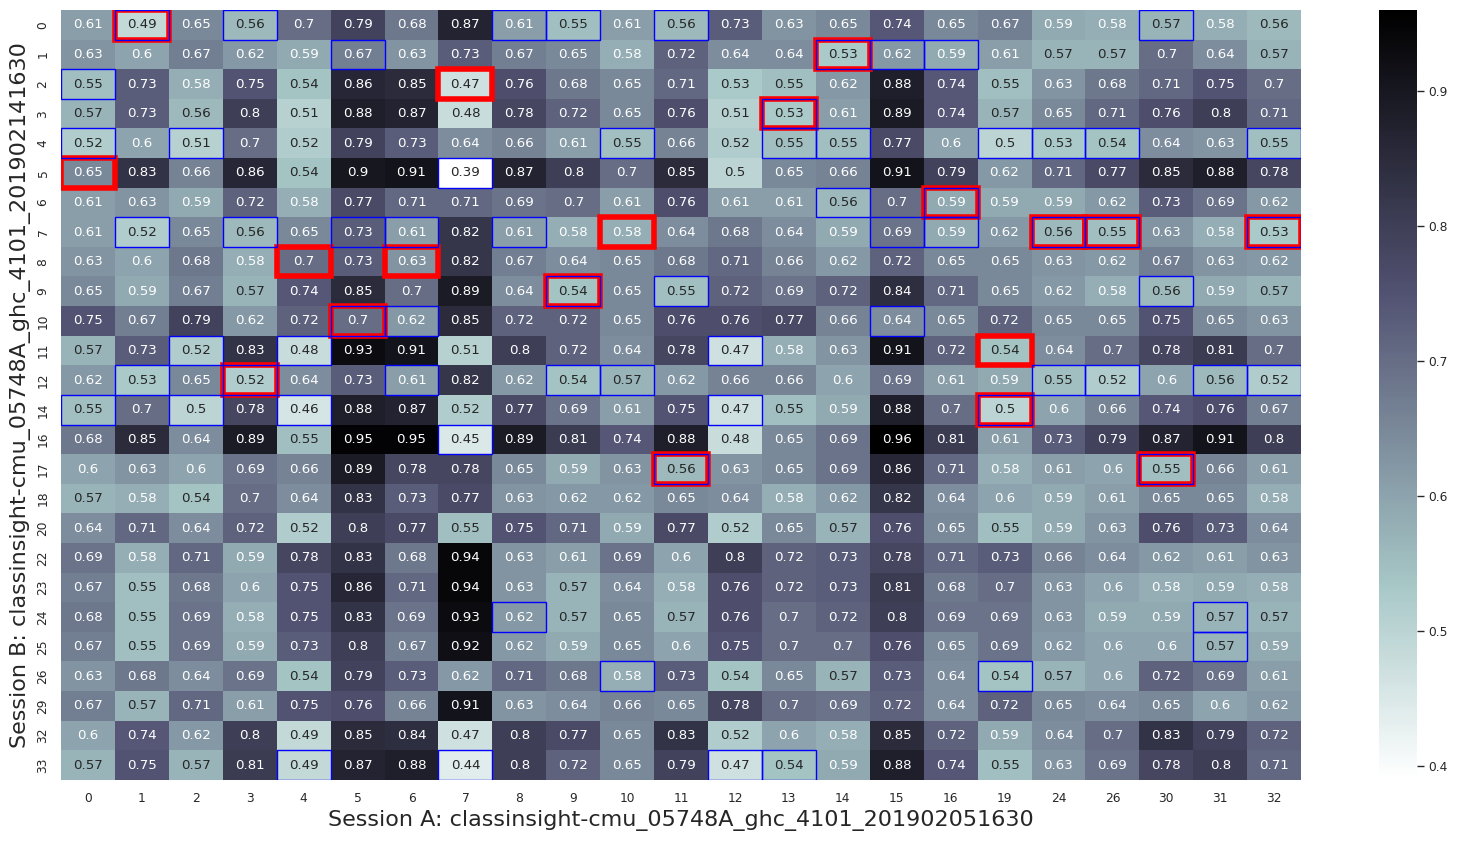

In [198]:
match_scores = {}
for idA in matching_info_dictB:
    match_scores[idA] = {}
    for idB in matching_info_dictB[idA]:
        match_matrix = matching_info_dictB[idA][idB]['match_matrix']
        match_distance = np.median(np.median(match_matrix,axis=1))
        match_scores[idA][idB] = match_distance

df_matching = pd.DataFrame(match_scores)

#--------
fig, axn = plt.subplots(1,1,figsize=(20,10))
sns.heatmap(df_matching.round(2), annot=True,ax=axn,cmap='bone_r')
for gtA in map(int, gt_map):
    for gtB in map(int, gt_map[str(gtA)]):
        if (gtA>=0) and (gtB>=0):
            if (gtA in df_matching.columns) and (gtB in df_matching.index):
                locA, locB = df_matching.columns.get_loc(gtA), df_matching.index.get_loc(gtB)
                axn.add_patch(Rectangle((locA, locB), 1, 1, fill=False, edgecolor='red', lw=4))

for locA in range(df_matching.shape[1]):
    locBs = df_matching.iloc[:,locA].argsort()[:3]
    for locB in locBs:
        axn.add_patch(Rectangle((locA, locB), 1, 1, fill=False, edgecolor='blue', lw=1))


axn.set_xlabel(f"Session A: {sessionA}",fontsize=16)
axn.set_ylabel(f"Session B: {sessionB}",fontsize=16)
plt.savefig(f'plots/Method2b_{course}_{sessionA.split("_")[-1]}_{sessionB.split("_")[-1]}.png',dpi=400,bbox_inches='tight')